<a href="https://colab.research.google.com/github/beruscoder/image_generation/blob/main/assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install albumentations wandb
import os, json
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import make_grid
from PIL import Image
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2
import wandb

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

Using device: cuda


In [2]:
class PolygonColorDataset(Dataset):
    def __init__(self, root_dir, json_file, transform=None, color_vocab=None, synthetic_factor=1):
        self.root_dir = root_dir
        self.transform = transform
        self.synthetic_factor = synthetic_factor

        with open(json_file, 'r') as f:
            self.data = json.load(f)

        if color_vocab is None:
            unique_colors = sorted(set(d["colour"] for d in self.data))
            self.color_vocab = {c: i for i, c in enumerate(unique_colors)}
        else:
            self.color_vocab = color_vocab

    def __len__(self):
        return len(self.data) * (self.synthetic_factor + 1)

    def __getitem__(self, idx):
        original_idx = idx // (self.synthetic_factor + 1)
        item = self.data[original_idx]
        input_path = os.path.join(self.root_dir, "inputs", item["input_polygon"])
        output_path = os.path.join(self.root_dir, "outputs", item["output_image"])
        color_name = item["colour"]

        input_img = np.array(Image.open(input_path).convert("L"))
        output_img = np.array(Image.open(output_path).convert("RGB"))


        if idx % (self.synthetic_factor + 1) > 0:
            synthetic_transform = A.Compose([
                A.Rotate(limit=30, p=1.0),
                A.RandomScale(scale_limit=0.1, p=0.5),
                A.ColorJitter(brightness=0.1, contrast=0.1, p=0.5),
            ])
            augmented = synthetic_transform(image=input_img, mask=output_img)
            input_img, output_img = augmented["image"], augmented["mask"]

        if self.transform:
            augmented = self.transform(image=input_img, mask=output_img)
            input_img = augmented["image"].float() / 255.0
            output_img = augmented["mask"].permute(2, 0, 1).float() / 255.0
        else:
            input_img = torch.tensor(input_img).unsqueeze(0).float() / 255.0
            output_img = torch.tensor(output_img).permute(2, 0, 1).float() / 255.0

        color_idx = self.color_vocab[color_name]
        return input_img, color_idx, output_img

In [3]:
import cv2
train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=45, p=0.7),
    A.RandomScale(scale_limit=0.2, p=0.5),
    A.Affine(shear=20, p=0.5),
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, p=0.5),
    A.PadIfNeeded(min_height=128, min_width=128, border_mode=cv2.BORDER_CONSTANT, value=0, p=1.0),  # Pad to 128x128
    A.RandomCrop(height=128, width=128, p=0.5),  # Crop after padding
    A.Resize(128, 128),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(128, 128),
    ToTensorV2()
])

/tmp/ipython-input-1766750052.py:9: UserWarning: Argument(s) 'value' are not valid for transform PadIfNeeded
  A.PadIfNeeded(min_height=128, min_width=128, border_mode=cv2.BORDER_CONSTANT, value=0, p=1.0),  # Pad to 128x128


In [4]:
# Load datasets with synthetic data (e.g., 2 synthetic samples per original)
train_dataset = PolygonColorDataset(
    root_dir="/content/drive/MyDrive/assignment/training",
    json_file="/content/drive/MyDrive/assignment/training/data.json",
    transform=train_transform,
    synthetic_factor=2
)
val_dataset = PolygonColorDataset(
    root_dir="/content/drive/MyDrive/assignment/validation",
    json_file="/content/drive/MyDrive/assignment/validation/data.json",
    transform=val_transform,
    color_vocab=train_dataset.color_vocab,
    synthetic_factor=0
)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

print("Train samples:", len(train_dataset), "Val samples:", len(val_dataset))
print("Color vocab:", train_dataset.color_vocab)

Train samples: 168 Val samples: 5
Color vocab: {'blue': 0, 'cyan': 1, 'green': 2, 'magenta': 3, 'orange': 4, 'purple': 5, 'red': 6, 'yellow': 7}


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FiLM(nn.Module):
    def __init__(self, cond_dim, num_features):
        super().__init__()
        self.gamma = nn.Linear(cond_dim, num_features)
        self.beta = nn.Linear(cond_dim, num_features)

    def forward(self, x, cond):
        gamma = self.gamma(cond).unsqueeze(-1).unsqueeze(-1)
        beta = self.beta(cond).unsqueeze(-1).unsqueeze(-1)
        return gamma * x + beta

class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, cond_dim=None, dilation=1, dropout_rate=0.2):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=dilation, dilation=dilation)
        self.bn1 = nn.BatchNorm2d(out_ch)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=dilation, dilation=dilation)
        self.bn2 = nn.BatchNorm2d(out_ch)
        self.film = FiLM(cond_dim, out_ch) if cond_dim else None
        self.dropout = nn.Dropout2d(dropout_rate) if dropout_rate > 0 else nn.Identity()

    def forward(self, x, cond=None):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        if self.film and cond is not None:
            x = self.film(x, cond)
        x = self.dropout(x)
        return x

class ConditionalUNet(nn.Module):
    def __init__(self, in_ch=1, out_ch=3, vocab_size=10, emb_dim=16):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim)

        # Encoder with dilated convolutions
        self.enc1 = ConvBlock(in_ch, 64, cond_dim=emb_dim)
        self.enc2 = ConvBlock(64, 128, cond_dim=emb_dim, dilation=1)
        self.enc3 = ConvBlock(128, 256, cond_dim=emb_dim, dilation=2)  # Dilated for larger receptive field
        self.enc4 = ConvBlock(256, 512, cond_dim=emb_dim, dilation=2)  # New layer

        self.bottleneck = ConvBlock(512, 1024, cond_dim=emb_dim, dilation=2)

        # Decoder
        self.dec4 = ConvBlock(512+1024, 512, cond_dim=emb_dim)  # New layer
        self.dec3 = ConvBlock(256+512, 256, cond_dim=emb_dim, dilation=1)
        self.dec2 = ConvBlock(128+256, 128, cond_dim=emb_dim, dilation=1)
        self.dec1 = ConvBlock(64+128, 64, cond_dim=emb_dim)

        self.final = nn.Conv2d(64, out_ch, 1)

        self.pool = nn.MaxPool2d(2)
        self.up = nn.ConvTranspose2d(1024, 1024, 2, stride=2)  # Updated for new layer

    def forward(self, img, color_idx):
        cond = self.embedding(color_idx)

        # Encoder
        x1 = self.enc1(img, cond)
        x2 = self.enc2(self.pool(x1), cond)
        x3 = self.enc3(self.pool(x2), cond)
        x4 = self.enc4(self.pool(x3), cond)

        x5 = self.bottleneck(self.pool(x4), cond)

        # Decoder
        d4 = self.up(x5)
        d4 = torch.cat([d4, x4], dim=1)
        d4 = self.dec4(d4, cond)

        d3 = F.interpolate(d4, scale_factor=2, mode='bilinear', align_corners=True)
        d3 = torch.cat([d3, x3], dim=1)
        d3 = self.dec3(d3, cond)

        d2 = F.interpolate(d3, scale_factor=2, mode='bilinear', align_corners=True)
        d2 = torch.cat([d2, x2], dim=1)
        d2 = self.dec2(d2, cond)

        d1 = F.interpolate(d2, scale_factor=2, mode='bilinear', align_corners=True)
        d1 = torch.cat([d1, x1], dim=1)
        d1 = self.dec1(d1, cond)

        out = torch.tanh(self.final(d1))  # Use tanh instead of sigmoid for [-1, 1] range
        return out

In [6]:
model = ConditionalUNet(in_ch=1, out_ch=3, vocab_size=len(train_dataset.color_vocab), emb_dim=16).to(device)
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) # Added scheduler

In [7]:
wandb.init(project="polygon-coloring", name="unet-cond")

wandb: Currently logged in as: lewisjansty (lewisjansty-indian-institute-of-information-technology-kota) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch 1/140 - Train Loss: 0.4950, Val Loss: 0.2379
✨ Saved new best model at epoch 1 (val_loss=0.2379)
Epoch 2/140 - Train Loss: 0.2782, Val Loss: 0.1048
✨ Saved new best model at epoch 2 (val_loss=0.1048)
Epoch 3/140 - Train Loss: 0.2080, Val Loss: 0.0950
✨ Saved new best model at epoch 3 (val_loss=0.0950)
Epoch 4/140 - Train Loss: 0.1804, Val Loss: 0.1003
Epoch 5/140 - Train Loss: 0.1761, Val Loss: 0.0762
✨ Saved new best model at epoch 5 (val_loss=0.0762)


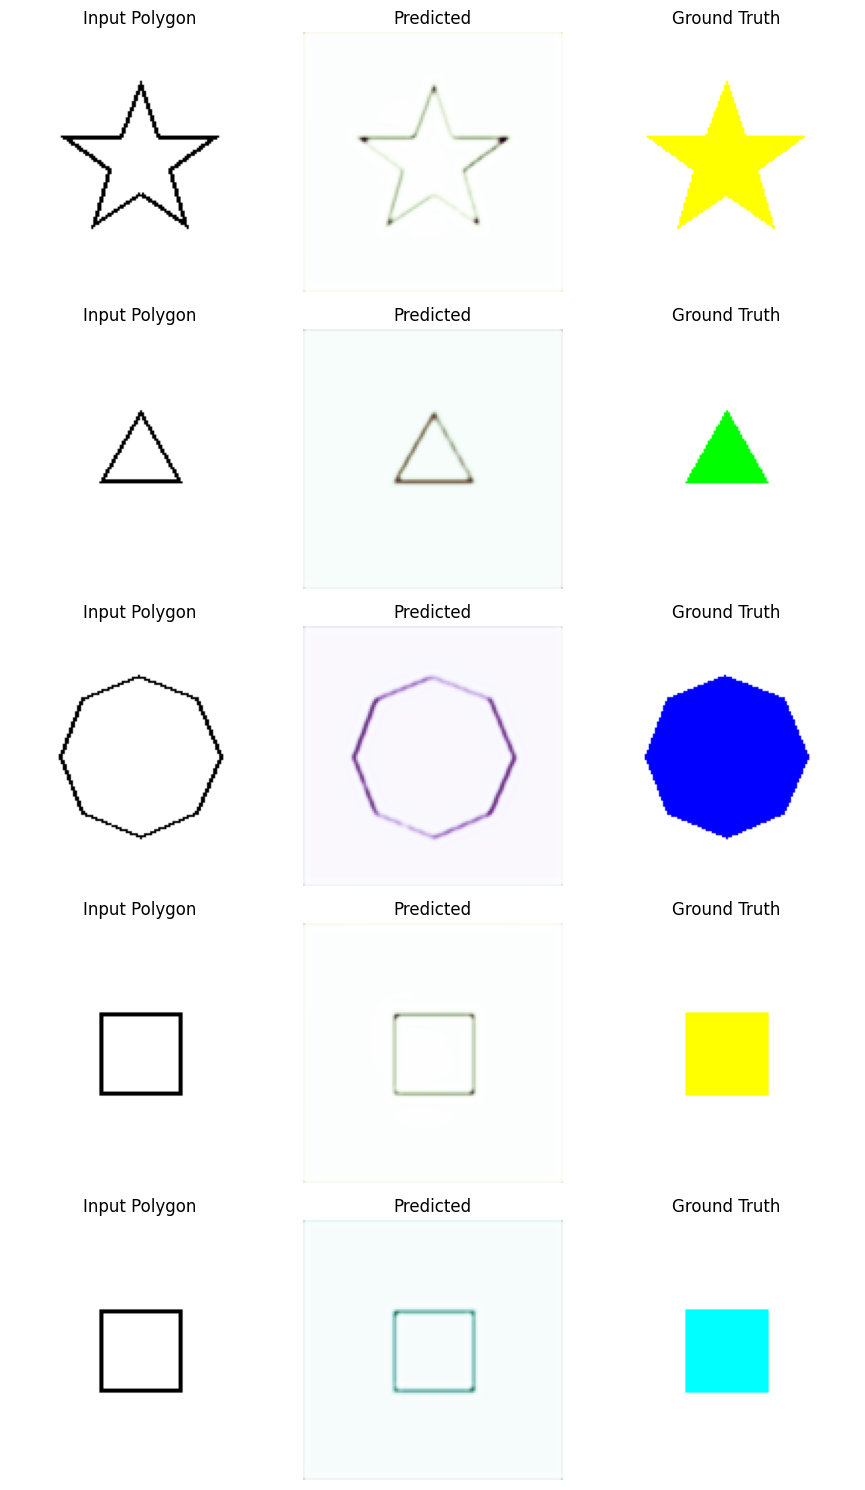

Epoch 6/140 - Train Loss: 0.1665, Val Loss: 0.0747
✨ Saved new best model at epoch 6 (val_loss=0.0747)
Epoch 7/140 - Train Loss: 0.1638, Val Loss: 0.0696
✨ Saved new best model at epoch 7 (val_loss=0.0696)
Epoch 8/140 - Train Loss: 0.1631, Val Loss: 0.0728
Epoch 9/140 - Train Loss: 0.1583, Val Loss: 0.0687
✨ Saved new best model at epoch 9 (val_loss=0.0687)
Epoch 10/140 - Train Loss: 0.1490, Val Loss: 0.0730


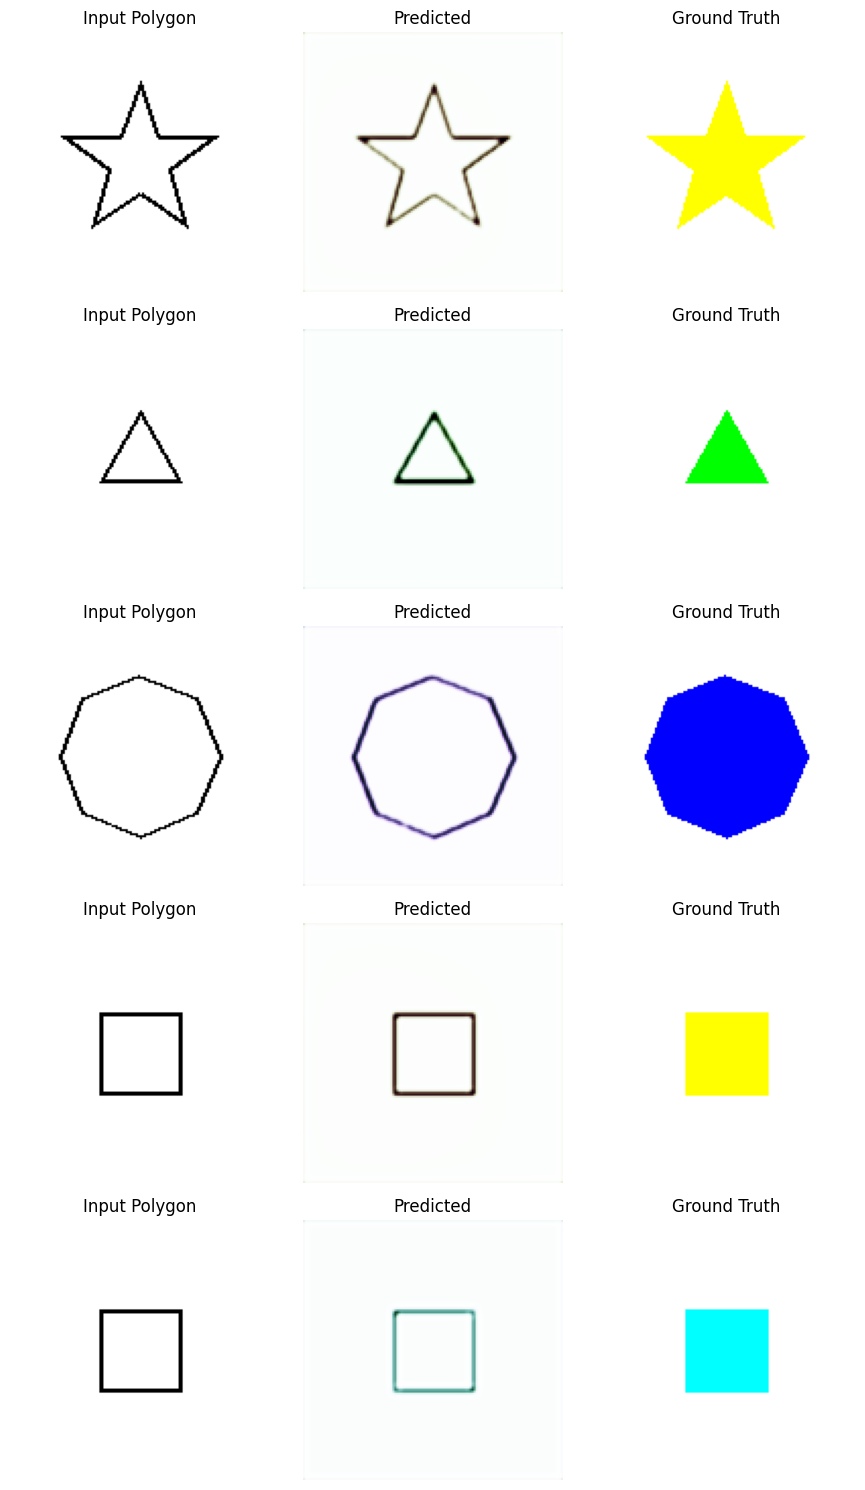

Epoch 11/140 - Train Loss: 0.1495, Val Loss: 0.0665
✨ Saved new best model at epoch 11 (val_loss=0.0665)
Epoch 12/140 - Train Loss: 0.1466, Val Loss: 0.0683
Epoch 13/140 - Train Loss: 0.1457, Val Loss: 0.0669
Epoch 14/140 - Train Loss: 0.1433, Val Loss: 0.0673
Epoch 15/140 - Train Loss: 0.1436, Val Loss: 0.0659
✨ Saved new best model at epoch 15 (val_loss=0.0659)


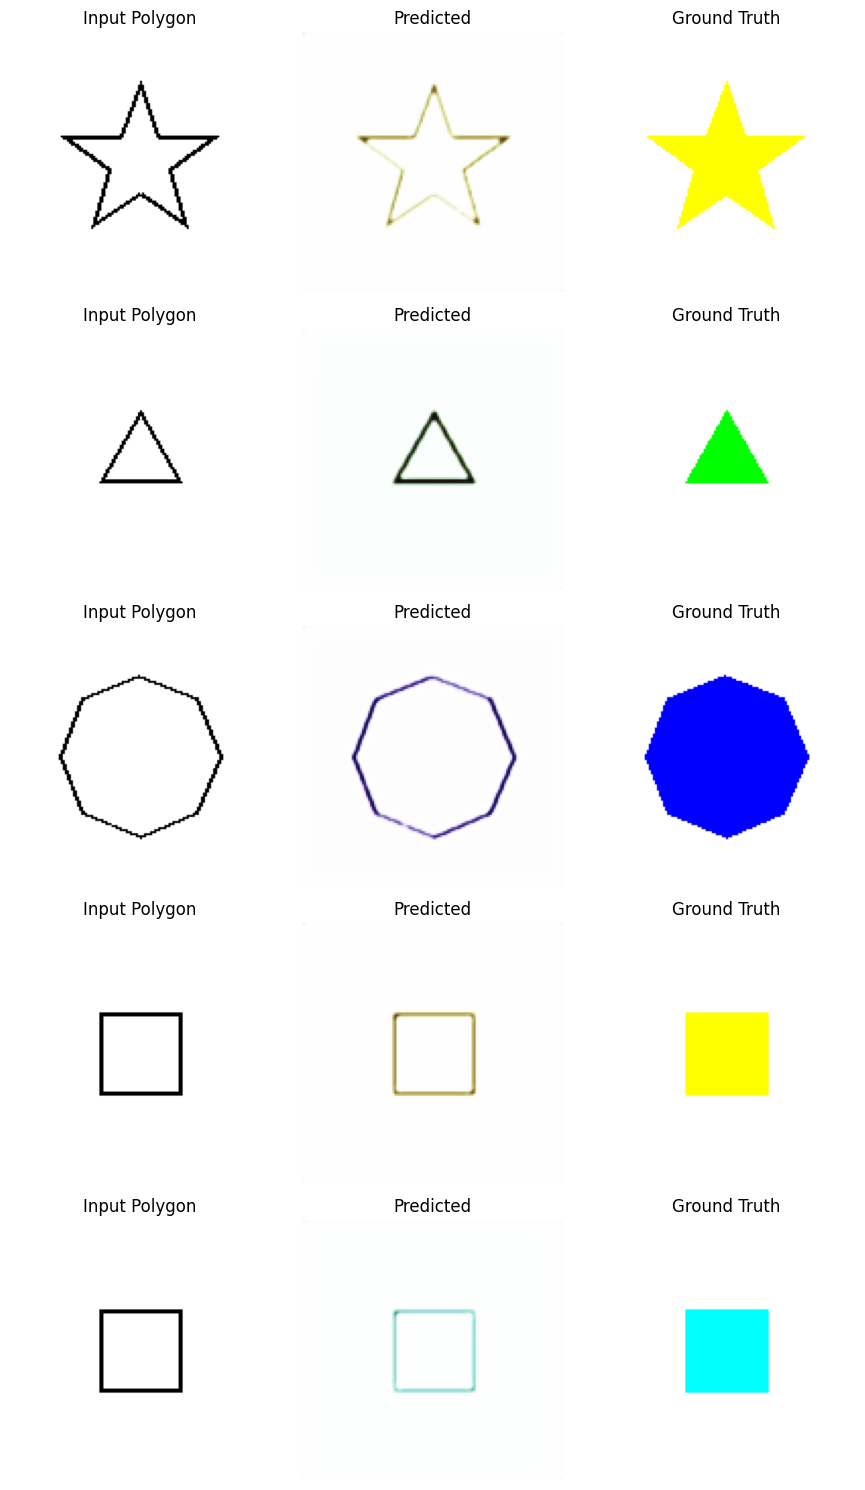

Epoch 16/140 - Train Loss: 0.1401, Val Loss: 0.0795
Epoch 17/140 - Train Loss: 0.1352, Val Loss: 0.0645
✨ Saved new best model at epoch 17 (val_loss=0.0645)
Epoch 18/140 - Train Loss: 0.1321, Val Loss: 0.0664
Epoch 19/140 - Train Loss: 0.1323, Val Loss: 0.0651
Epoch 20/140 - Train Loss: 0.1328, Val Loss: 0.0662


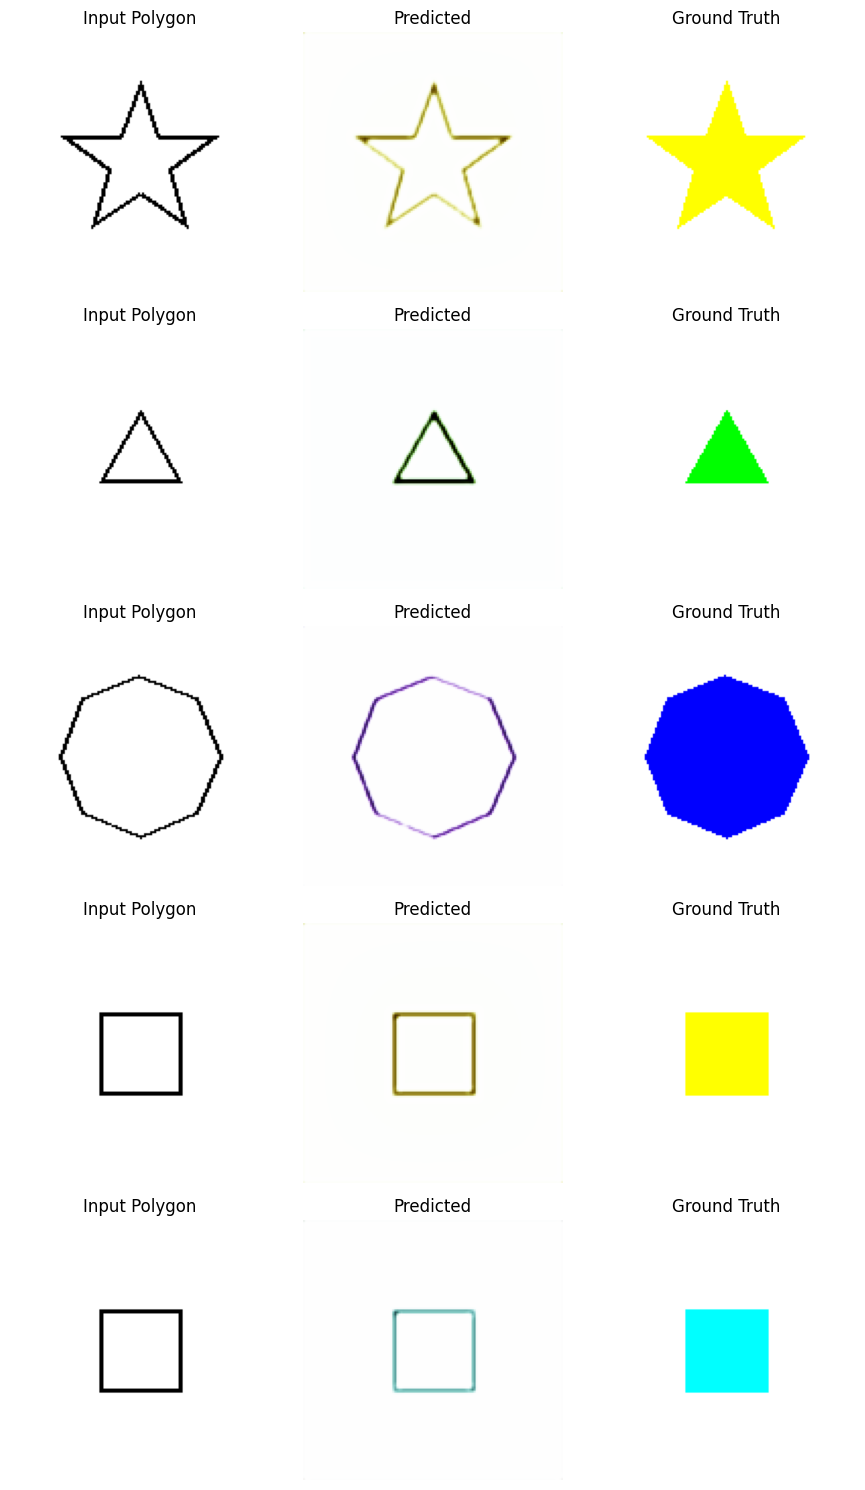

Epoch 21/140 - Train Loss: 0.1294, Val Loss: 0.0648
Epoch 22/140 - Train Loss: 0.1206, Val Loss: 0.0647
Epoch 23/140 - Train Loss: 0.1231, Val Loss: 0.0645
✨ Saved new best model at epoch 23 (val_loss=0.0645)
Epoch 24/140 - Train Loss: 0.1205, Val Loss: 0.0639
✨ Saved new best model at epoch 24 (val_loss=0.0639)
Epoch 25/140 - Train Loss: 0.1240, Val Loss: 0.0696


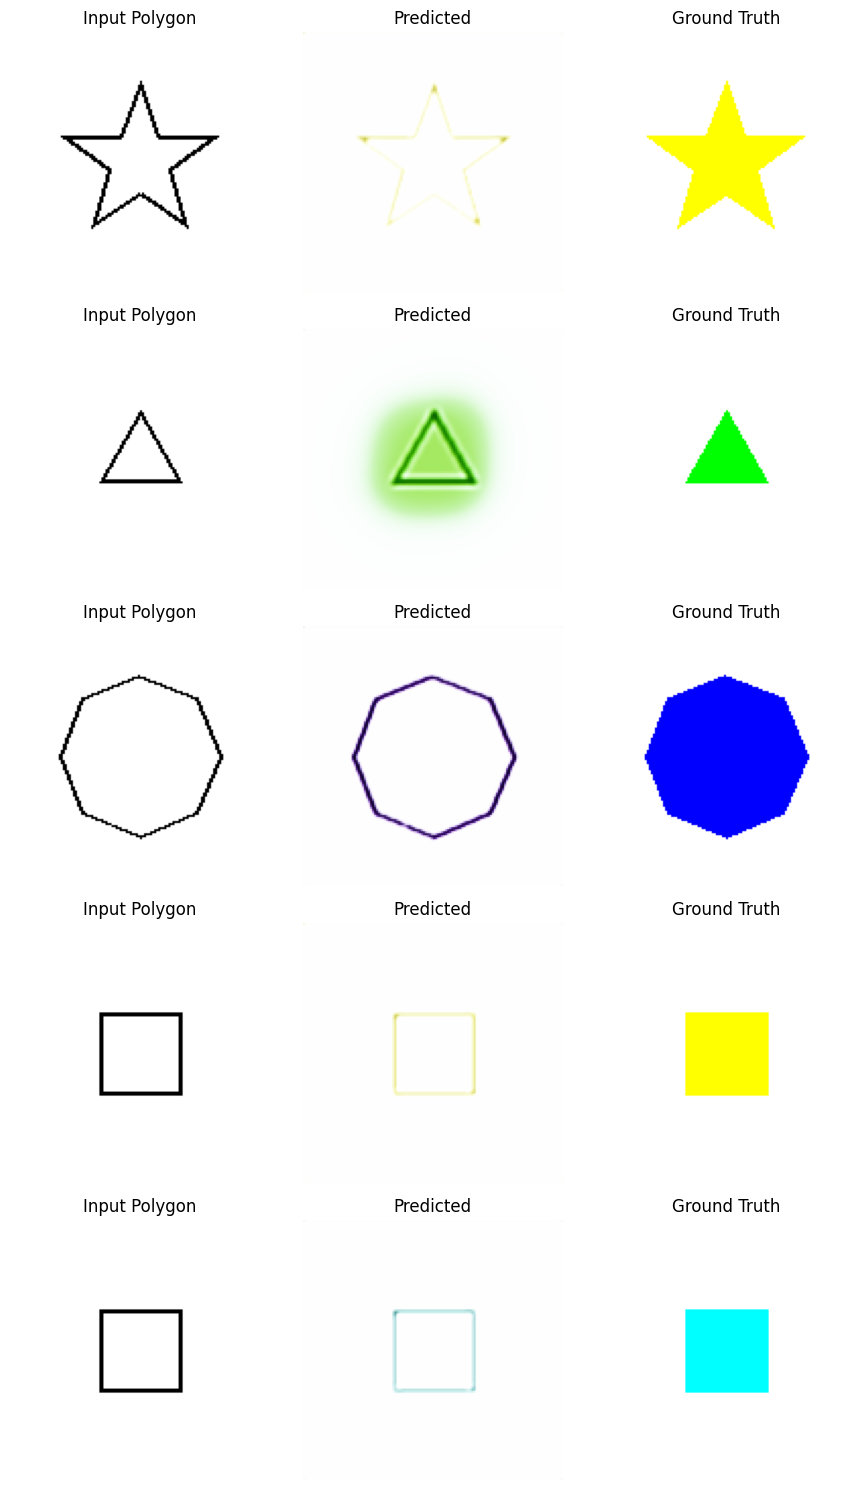

Epoch 26/140 - Train Loss: 0.1187, Val Loss: 0.2175
Epoch 27/140 - Train Loss: 0.1186, Val Loss: 0.0791
Epoch 28/140 - Train Loss: 0.1157, Val Loss: 0.0634
✨ Saved new best model at epoch 28 (val_loss=0.0634)
Epoch 29/140 - Train Loss: 0.1139, Val Loss: 0.0640
Epoch 30/140 - Train Loss: 0.1114, Val Loss: 0.0626
✨ Saved new best model at epoch 30 (val_loss=0.0626)


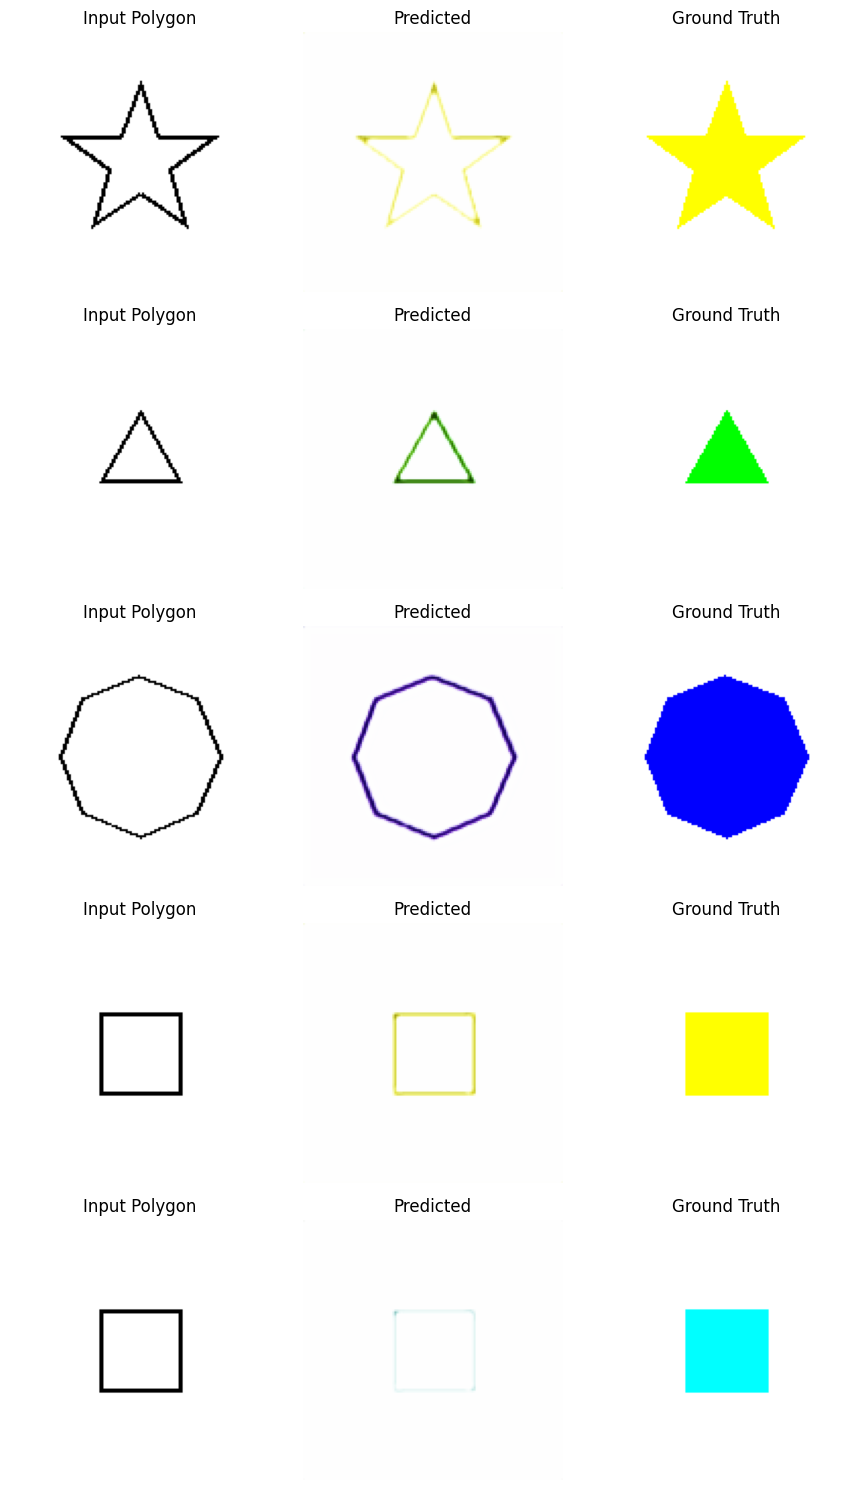

Epoch 31/140 - Train Loss: 0.1079, Val Loss: 0.0635
Epoch 32/140 - Train Loss: 0.1082, Val Loss: 0.0628
Epoch 33/140 - Train Loss: 0.1044, Val Loss: 0.0622
✨ Saved new best model at epoch 33 (val_loss=0.0622)
Epoch 34/140 - Train Loss: 0.1074, Val Loss: 0.0614
✨ Saved new best model at epoch 34 (val_loss=0.0614)
Epoch 35/140 - Train Loss: 0.1059, Val Loss: 0.0619


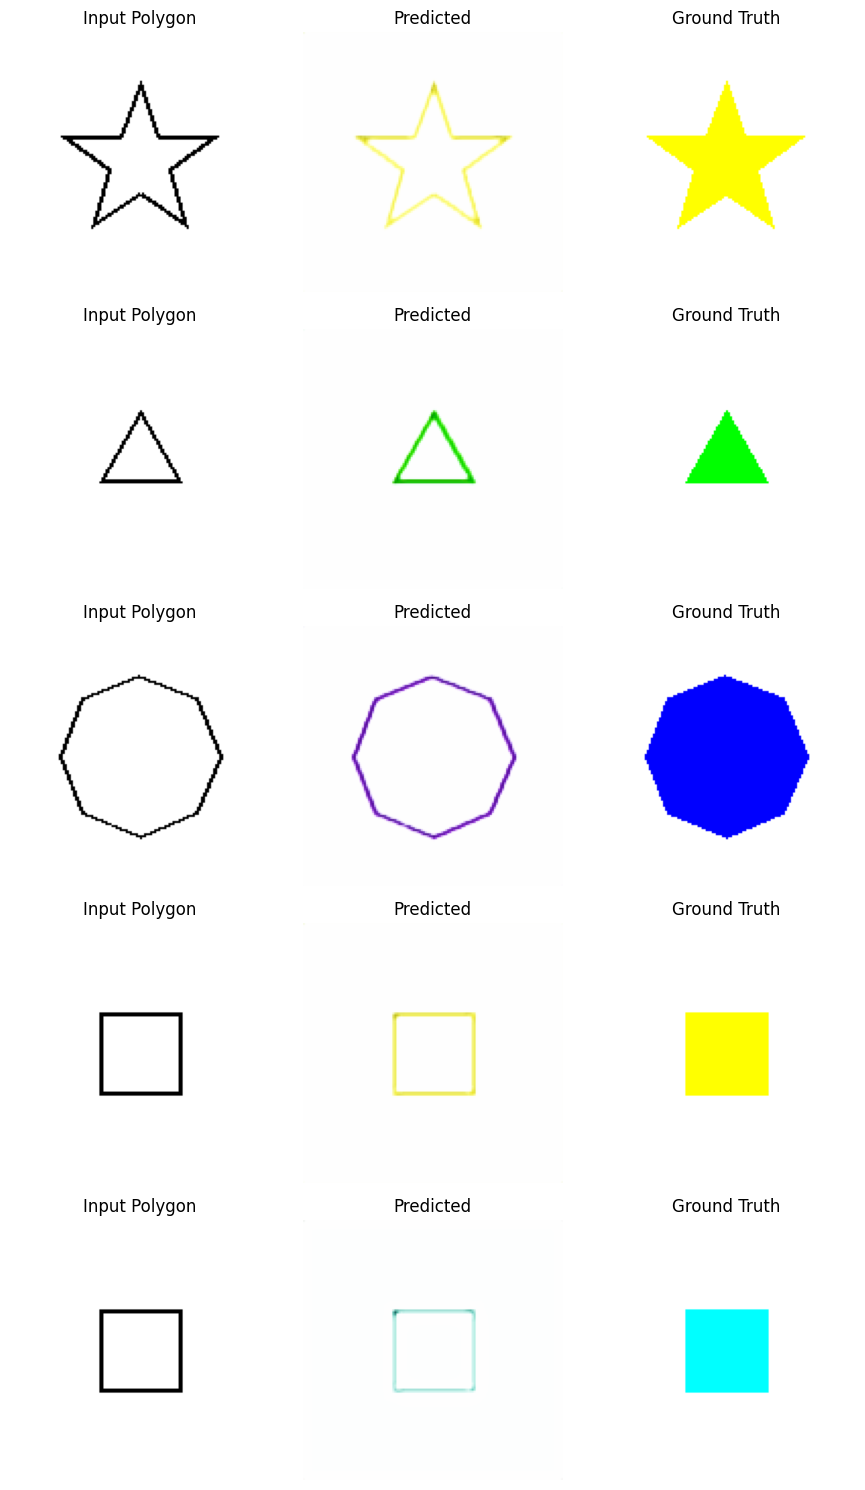

Epoch 36/140 - Train Loss: 0.1026, Val Loss: 0.0611
✨ Saved new best model at epoch 36 (val_loss=0.0611)
Epoch 37/140 - Train Loss: 0.1011, Val Loss: 0.0608
✨ Saved new best model at epoch 37 (val_loss=0.0608)
Epoch 38/140 - Train Loss: 0.1035, Val Loss: 0.0611
Epoch 39/140 - Train Loss: 0.1033, Val Loss: 0.0608
Epoch 40/140 - Train Loss: 0.0965, Val Loss: 0.0601
✨ Saved new best model at epoch 40 (val_loss=0.0601)


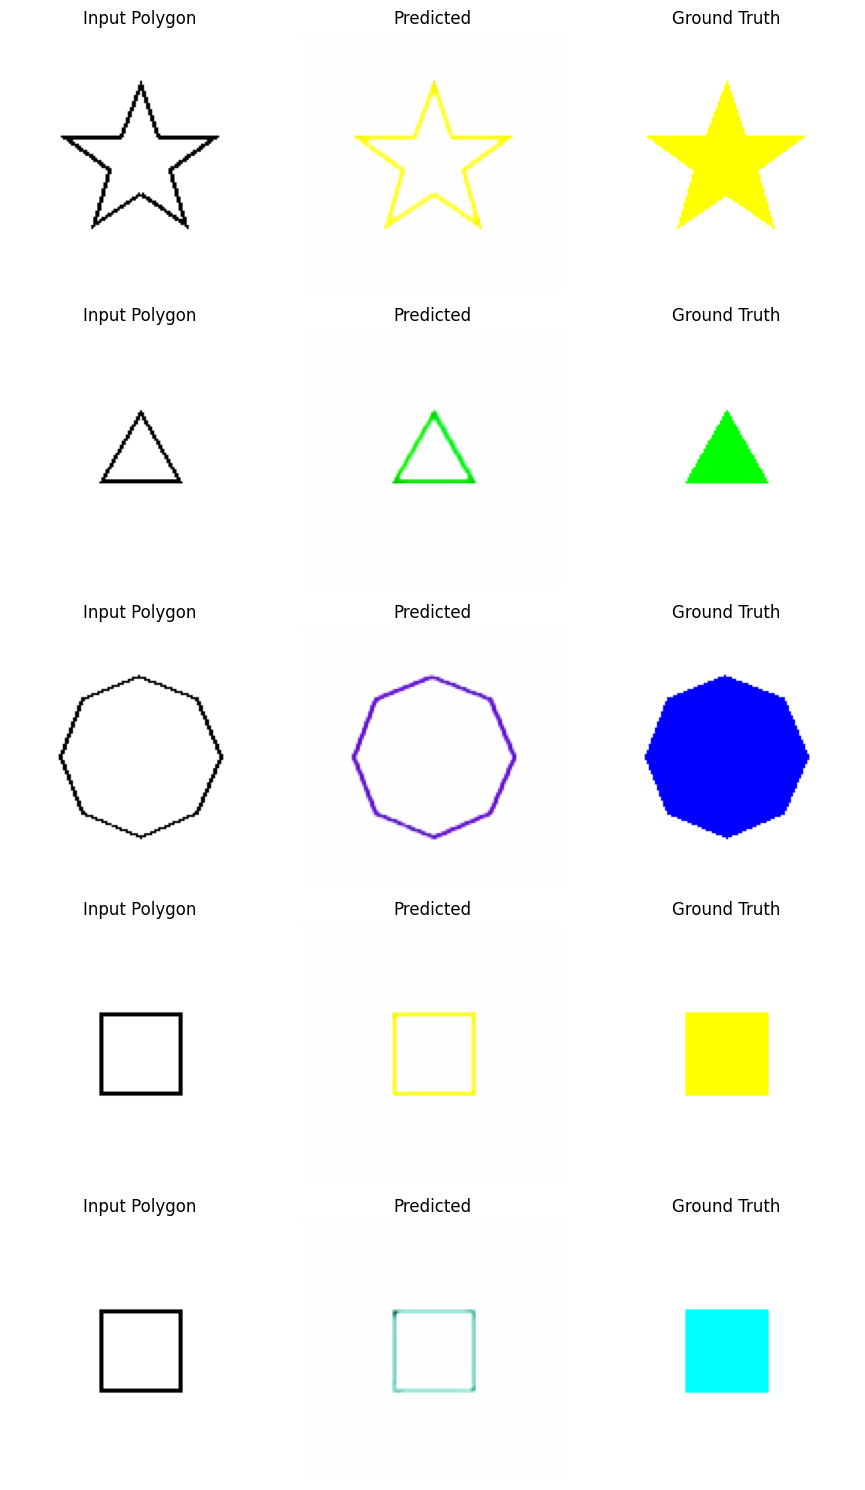

Epoch 41/140 - Train Loss: 0.0991, Val Loss: 0.0606
Epoch 42/140 - Train Loss: 0.0982, Val Loss: 0.0611
Epoch 43/140 - Train Loss: 0.0988, Val Loss: 0.0593
✨ Saved new best model at epoch 43 (val_loss=0.0593)
Epoch 44/140 - Train Loss: 0.0970, Val Loss: 0.0599
Epoch 45/140 - Train Loss: 0.0948, Val Loss: 0.0592
✨ Saved new best model at epoch 45 (val_loss=0.0592)


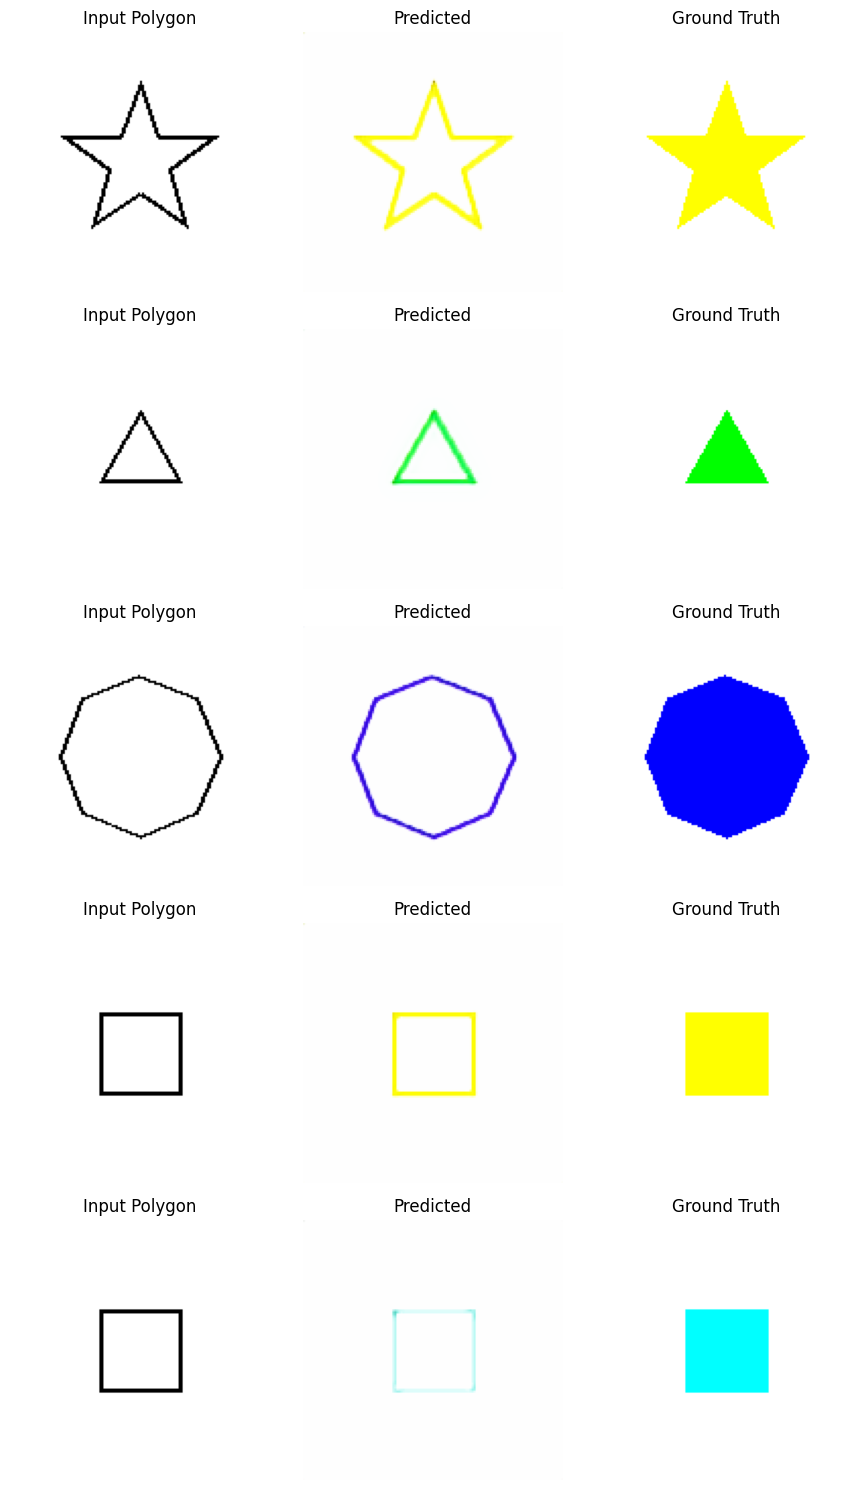

Epoch 46/140 - Train Loss: 0.0929, Val Loss: 0.0594
Epoch 47/140 - Train Loss: 0.0924, Val Loss: 0.0589
✨ Saved new best model at epoch 47 (val_loss=0.0589)
Epoch 48/140 - Train Loss: 0.0889, Val Loss: 0.0566
✨ Saved new best model at epoch 48 (val_loss=0.0566)
Epoch 49/140 - Train Loss: 0.0868, Val Loss: 0.0721
Epoch 50/140 - Train Loss: 0.0908, Val Loss: 0.0665


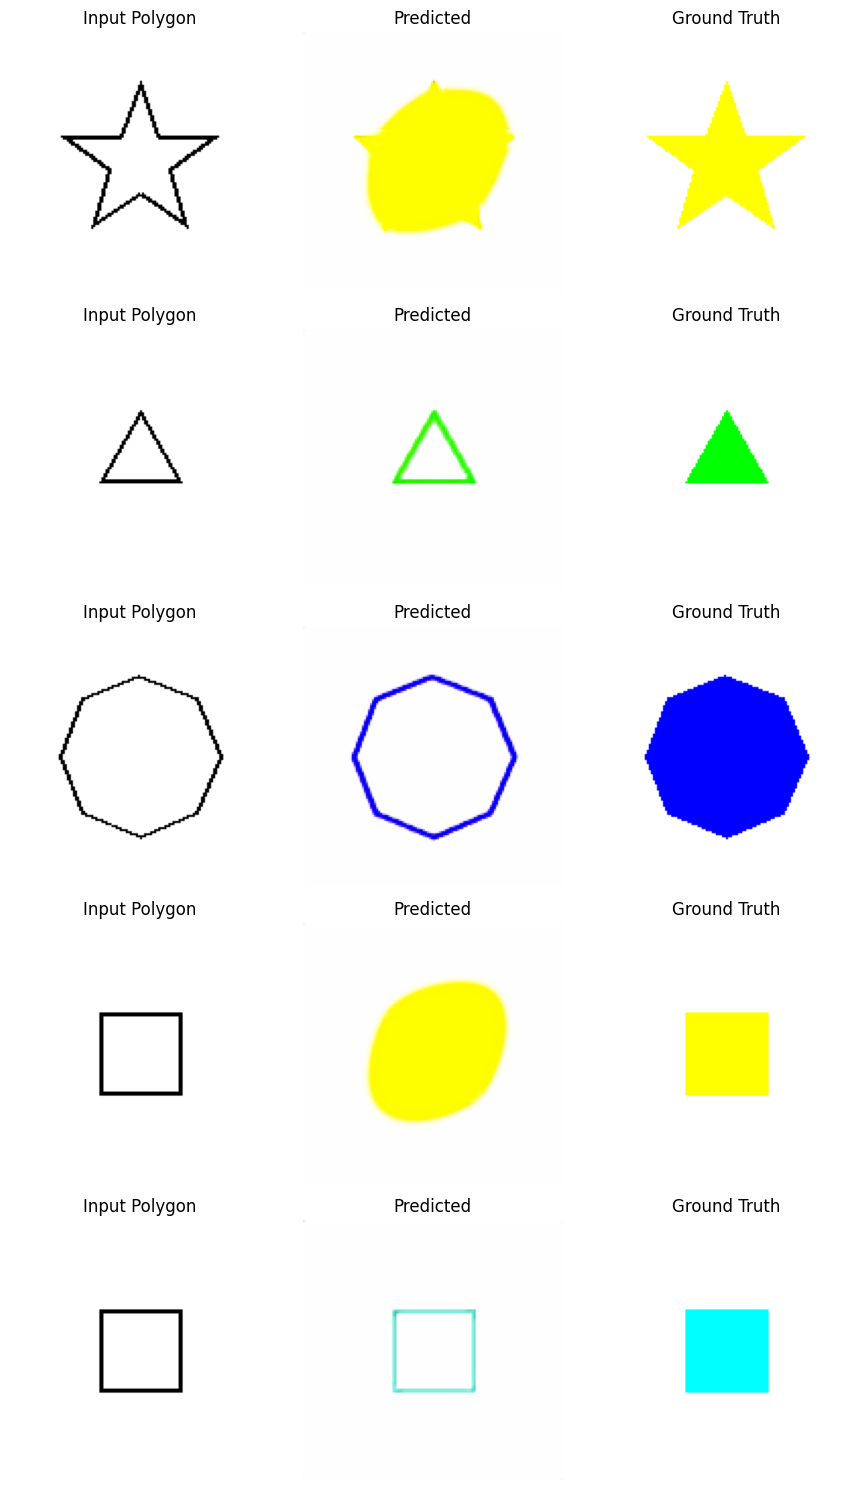

Epoch 51/140 - Train Loss: 0.0937, Val Loss: 0.0584
Epoch 52/140 - Train Loss: 0.0934, Val Loss: 0.0572
Epoch 53/140 - Train Loss: 0.0911, Val Loss: 0.0590
Epoch 54/140 - Train Loss: 0.0905, Val Loss: 0.0725
Epoch 55/140 - Train Loss: 0.0871, Val Loss: 0.0880


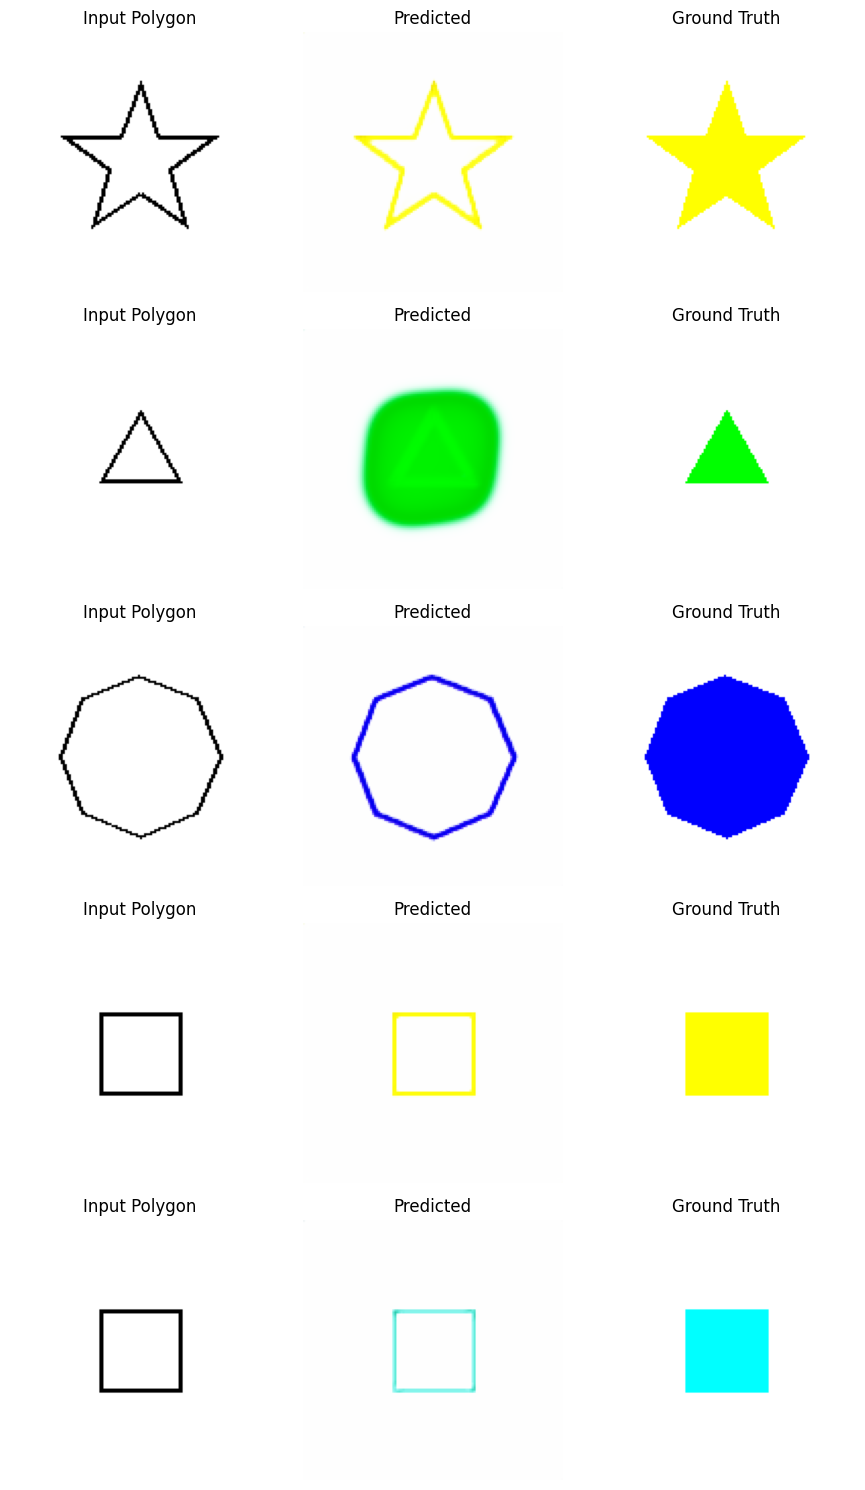

Epoch 56/140 - Train Loss: 0.0884, Val Loss: 0.1091
Epoch 57/140 - Train Loss: 0.0822, Val Loss: 0.0521
✨ Saved new best model at epoch 57 (val_loss=0.0521)
Epoch 58/140 - Train Loss: 0.0754, Val Loss: 0.1700
Epoch 59/140 - Train Loss: 0.0727, Val Loss: 0.0737
Epoch 60/140 - Train Loss: 0.0686, Val Loss: 0.1038


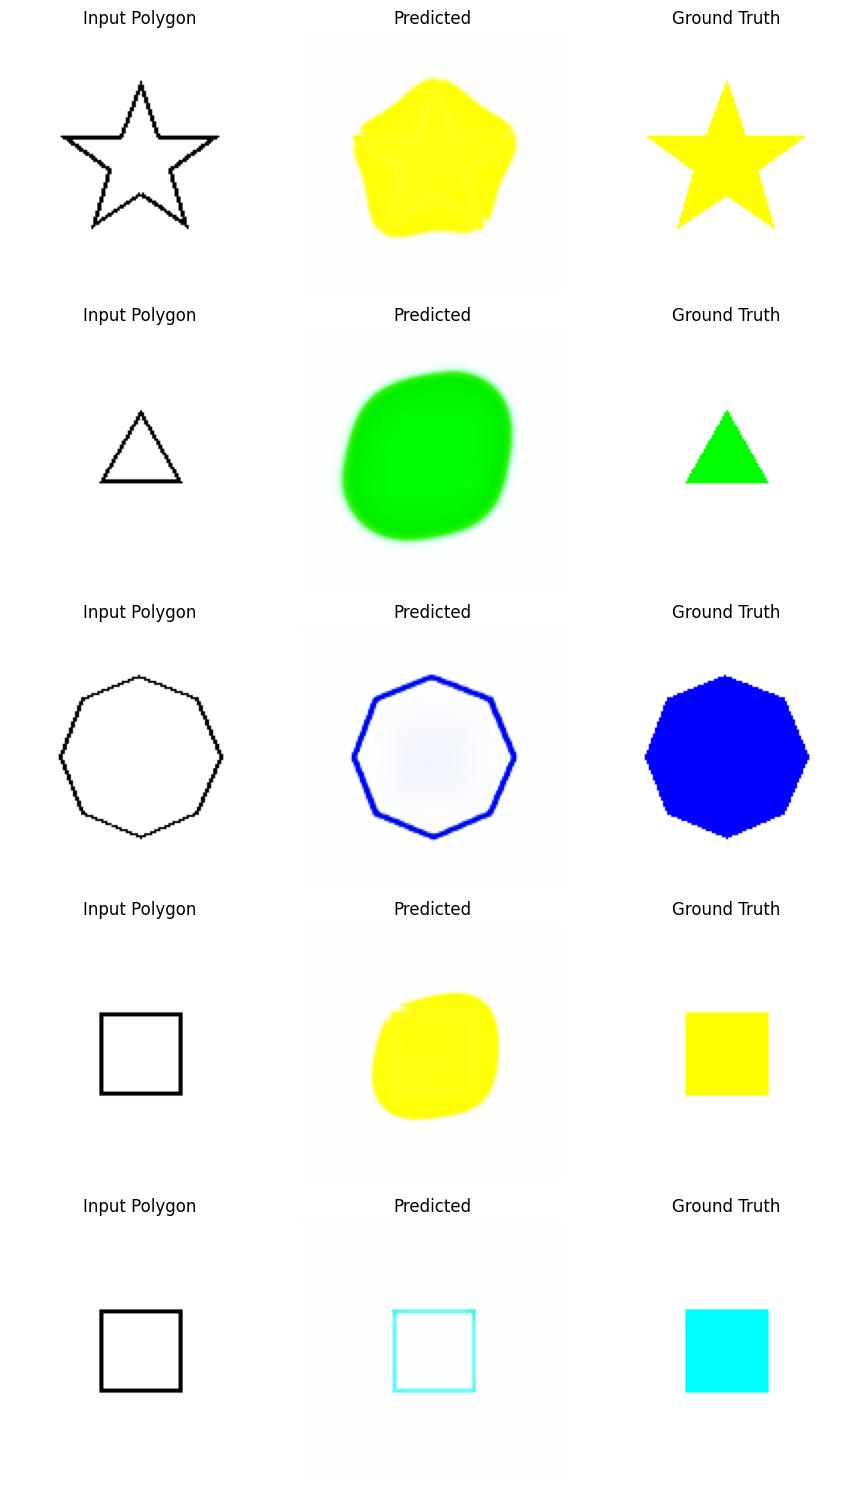

Epoch 61/140 - Train Loss: 0.0651, Val Loss: 0.0740
Epoch 62/140 - Train Loss: 0.0660, Val Loss: 0.0863
Epoch 63/140 - Train Loss: 0.0629, Val Loss: 0.0656
Epoch 64/140 - Train Loss: 0.0607, Val Loss: 0.0802
Epoch 65/140 - Train Loss: 0.0575, Val Loss: 0.0867


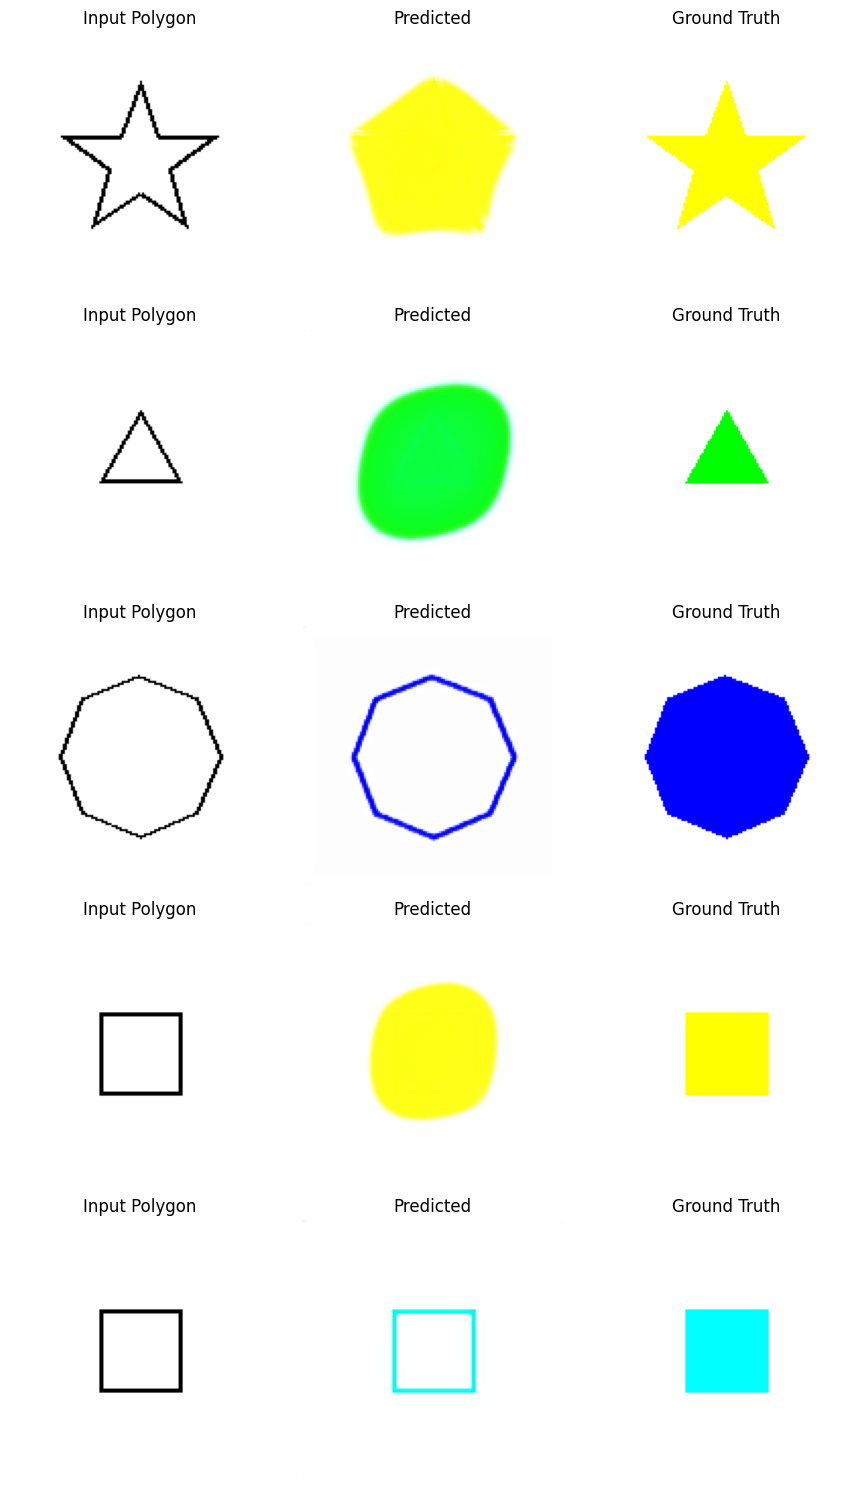

Epoch 66/140 - Train Loss: 0.0558, Val Loss: 0.0573
Epoch 67/140 - Train Loss: 0.0530, Val Loss: 0.0688
Epoch 68/140 - Train Loss: 0.0535, Val Loss: 0.0654
Epoch 69/140 - Train Loss: 0.0522, Val Loss: 0.0919
Epoch 70/140 - Train Loss: 0.0538, Val Loss: 0.0677


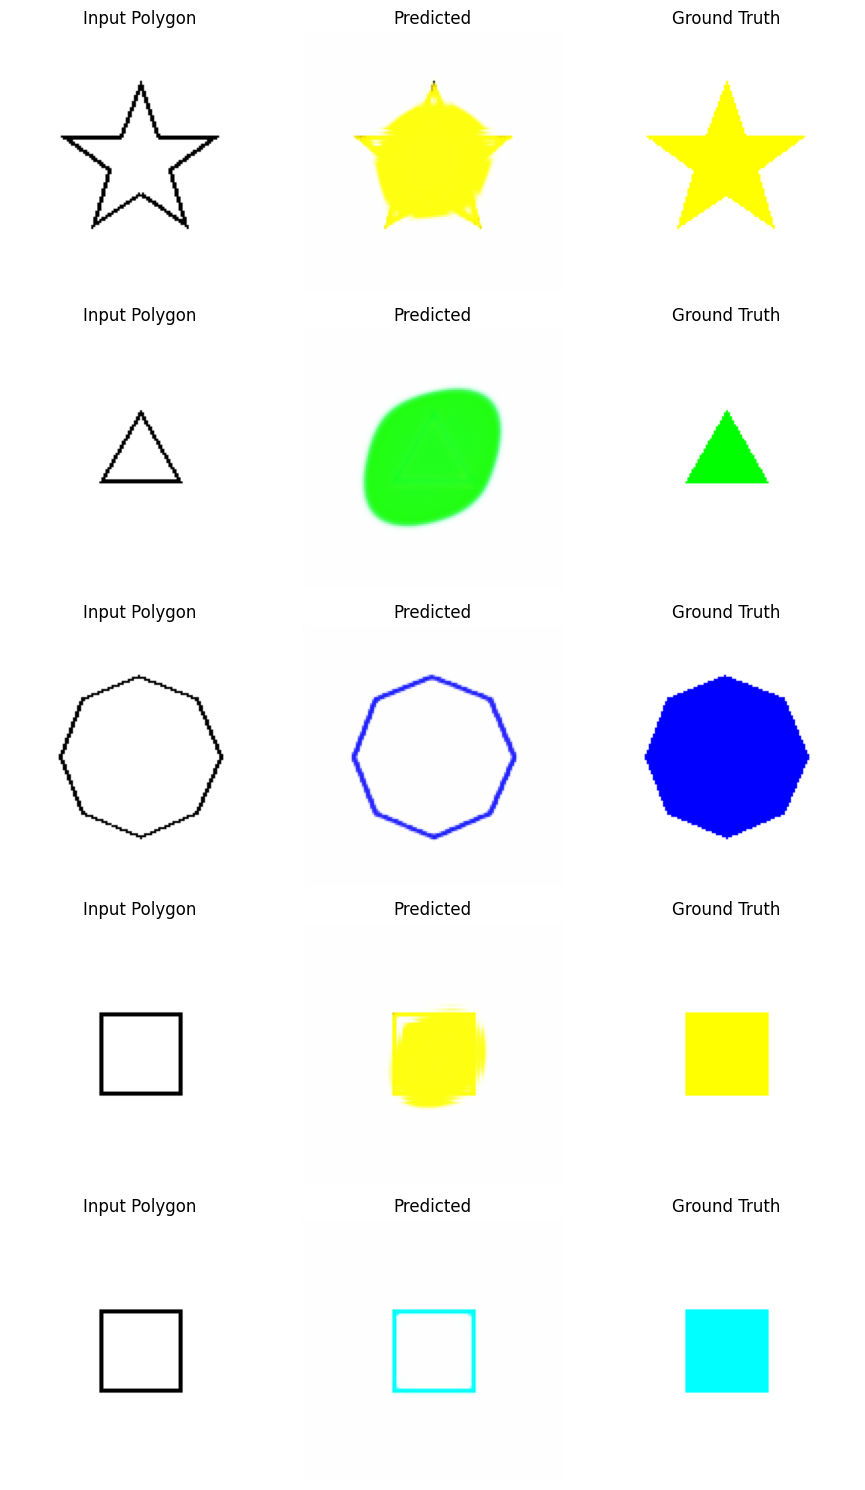

Epoch 71/140 - Train Loss: 0.0505, Val Loss: 0.0658
Epoch 72/140 - Train Loss: 0.0513, Val Loss: 0.0484
✨ Saved new best model at epoch 72 (val_loss=0.0484)
Epoch 73/140 - Train Loss: 0.0473, Val Loss: 0.0571
Epoch 74/140 - Train Loss: 0.0468, Val Loss: 0.0568
Epoch 75/140 - Train Loss: 0.0474, Val Loss: 0.0811


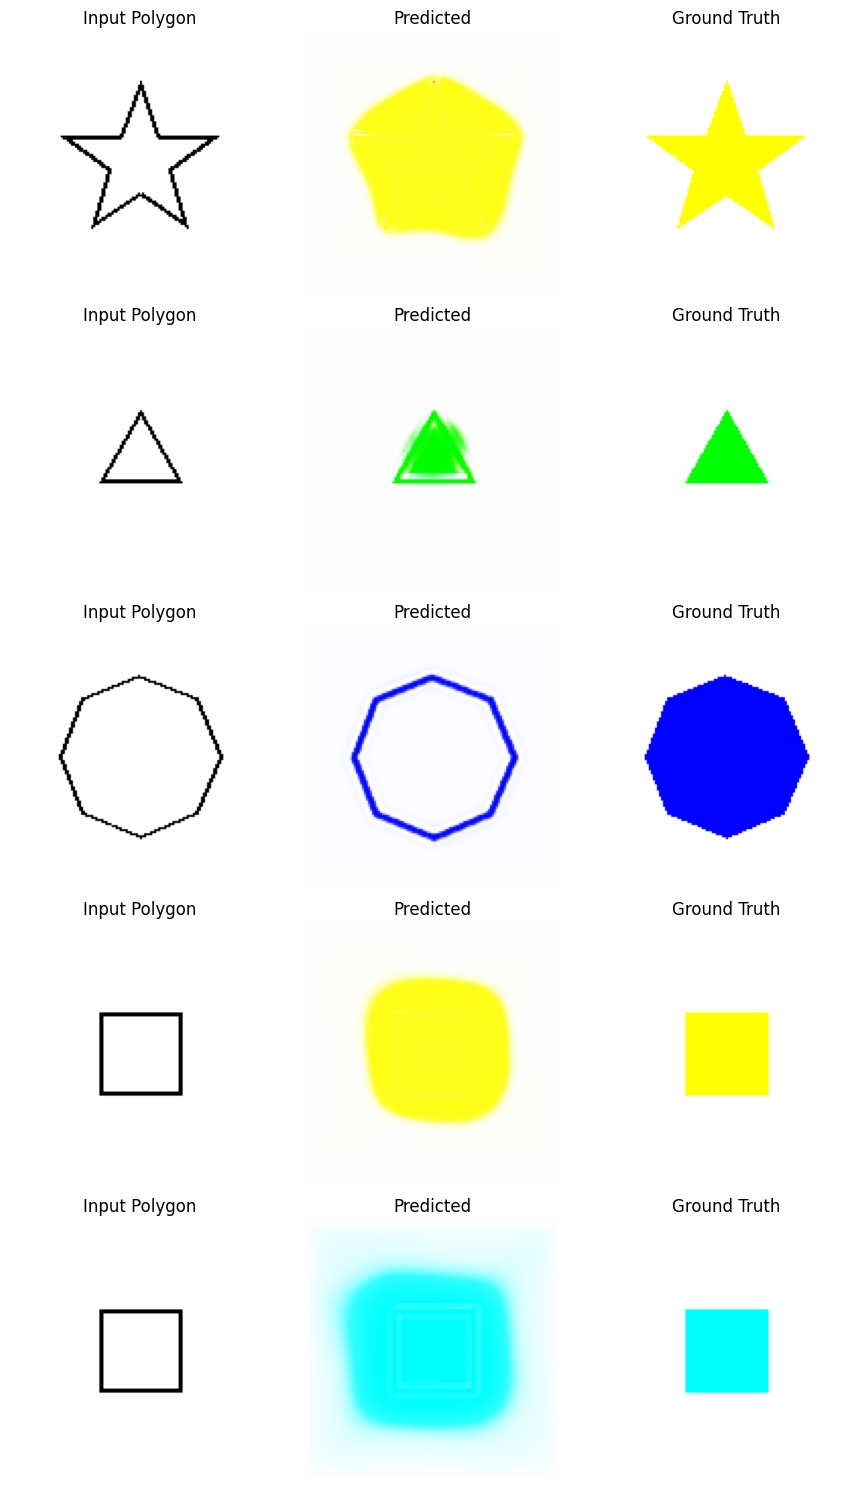

Epoch 76/140 - Train Loss: 0.0458, Val Loss: 0.0496
Epoch 77/140 - Train Loss: 0.0425, Val Loss: 0.0434
✨ Saved new best model at epoch 77 (val_loss=0.0434)
Epoch 78/140 - Train Loss: 0.0398, Val Loss: 0.0413
✨ Saved new best model at epoch 78 (val_loss=0.0413)
Epoch 79/140 - Train Loss: 0.0397, Val Loss: 0.0391
✨ Saved new best model at epoch 79 (val_loss=0.0391)
Epoch 80/140 - Train Loss: 0.0372, Val Loss: 0.0416


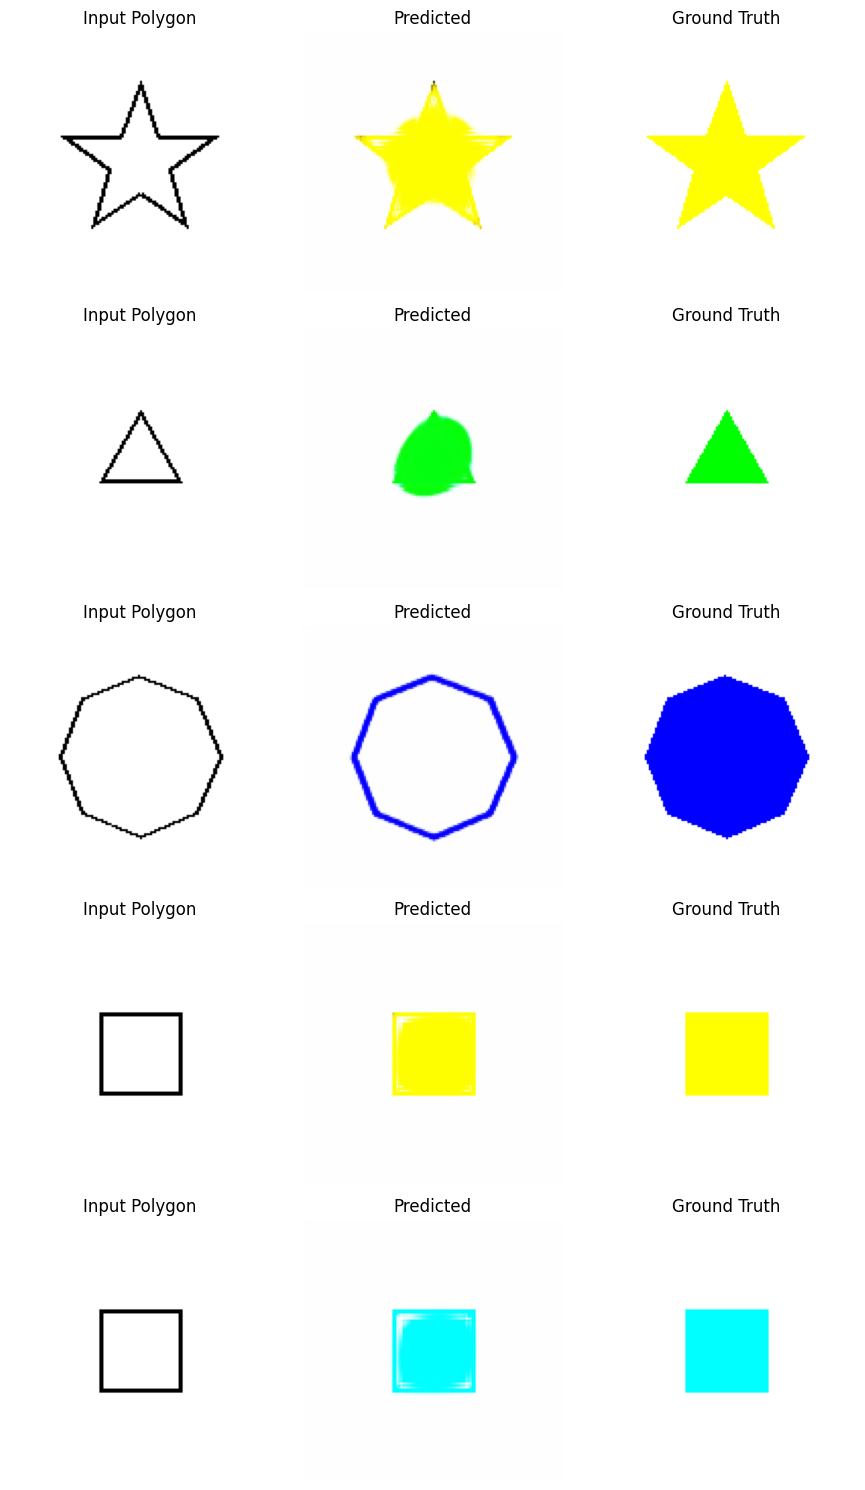

Epoch 81/140 - Train Loss: 0.0353, Val Loss: 0.0401
Epoch 82/140 - Train Loss: 0.0370, Val Loss: 0.0388
✨ Saved new best model at epoch 82 (val_loss=0.0388)
Epoch 83/140 - Train Loss: 0.0360, Val Loss: 0.0401
Epoch 84/140 - Train Loss: 0.0351, Val Loss: 0.0388
Epoch 85/140 - Train Loss: 0.0330, Val Loss: 0.0392


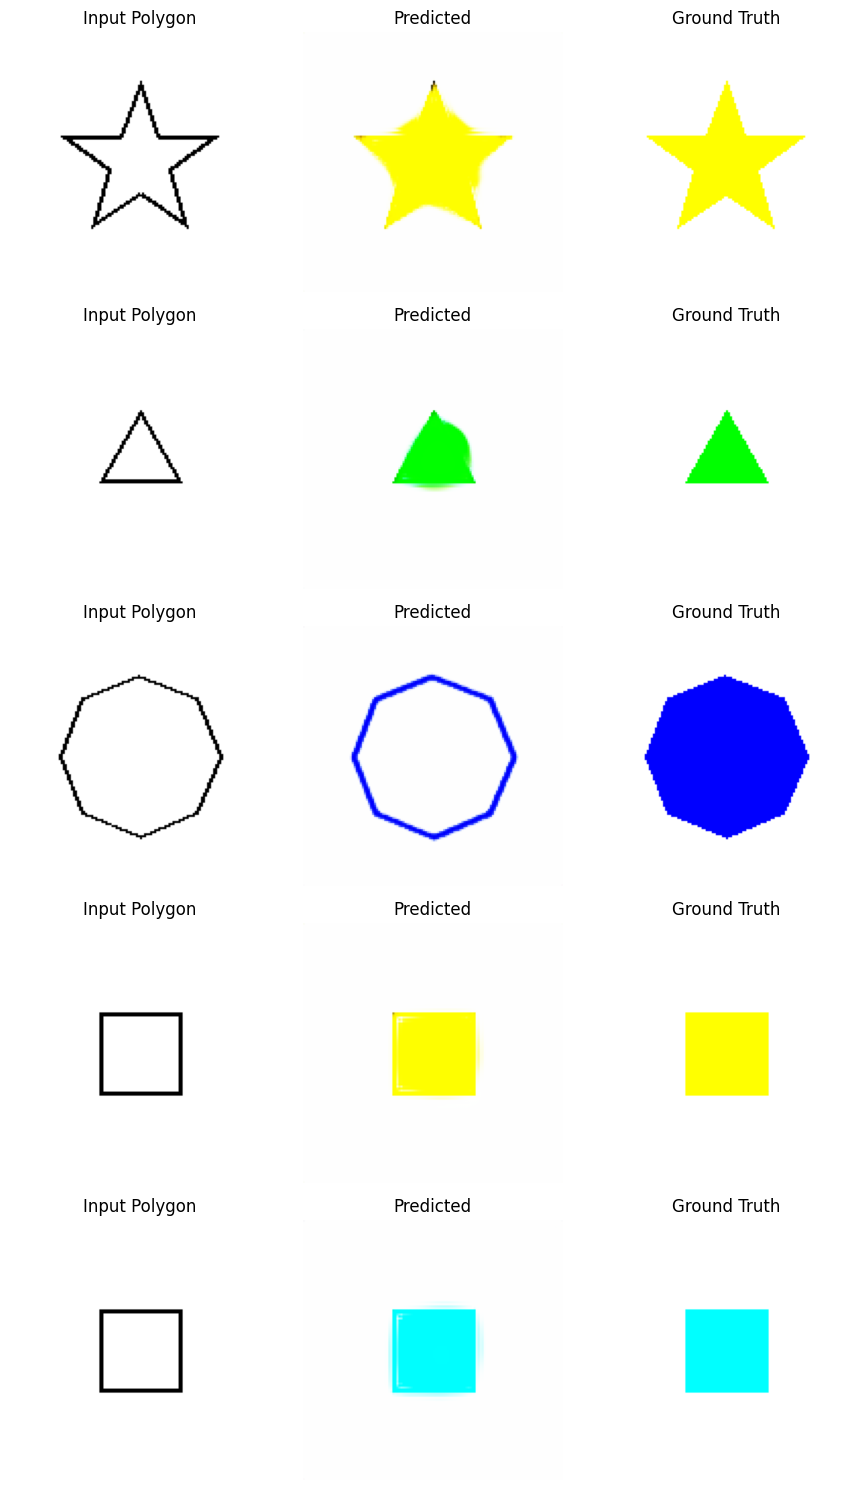

Epoch 86/140 - Train Loss: 0.0327, Val Loss: 0.0400
Epoch 87/140 - Train Loss: 0.0336, Val Loss: 0.0388
✨ Saved new best model at epoch 87 (val_loss=0.0388)
Epoch 88/140 - Train Loss: 0.0347, Val Loss: 0.0373
✨ Saved new best model at epoch 88 (val_loss=0.0373)
Epoch 89/140 - Train Loss: 0.0329, Val Loss: 0.0373
✨ Saved new best model at epoch 89 (val_loss=0.0373)
Epoch 90/140 - Train Loss: 0.0325, Val Loss: 0.0382


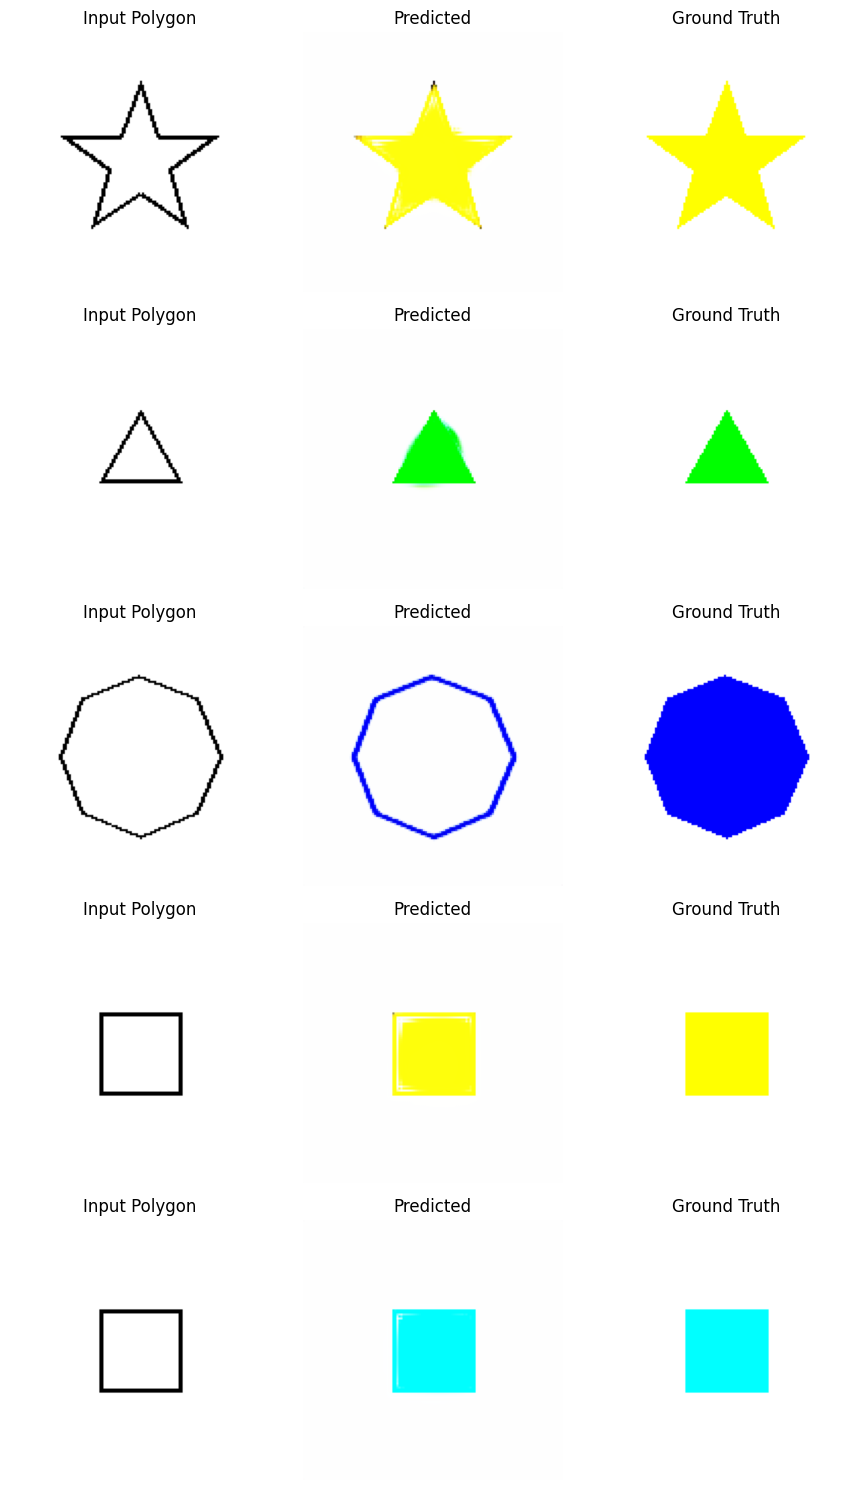

Epoch 91/140 - Train Loss: 0.0328, Val Loss: 0.0372
✨ Saved new best model at epoch 91 (val_loss=0.0372)
Epoch 92/140 - Train Loss: 0.0320, Val Loss: 0.0372
Epoch 93/140 - Train Loss: 0.0330, Val Loss: 0.0375
Epoch 94/140 - Train Loss: 0.0313, Val Loss: 0.0368
✨ Saved new best model at epoch 94 (val_loss=0.0368)
Epoch 95/140 - Train Loss: 0.0303, Val Loss: 0.0357
✨ Saved new best model at epoch 95 (val_loss=0.0357)


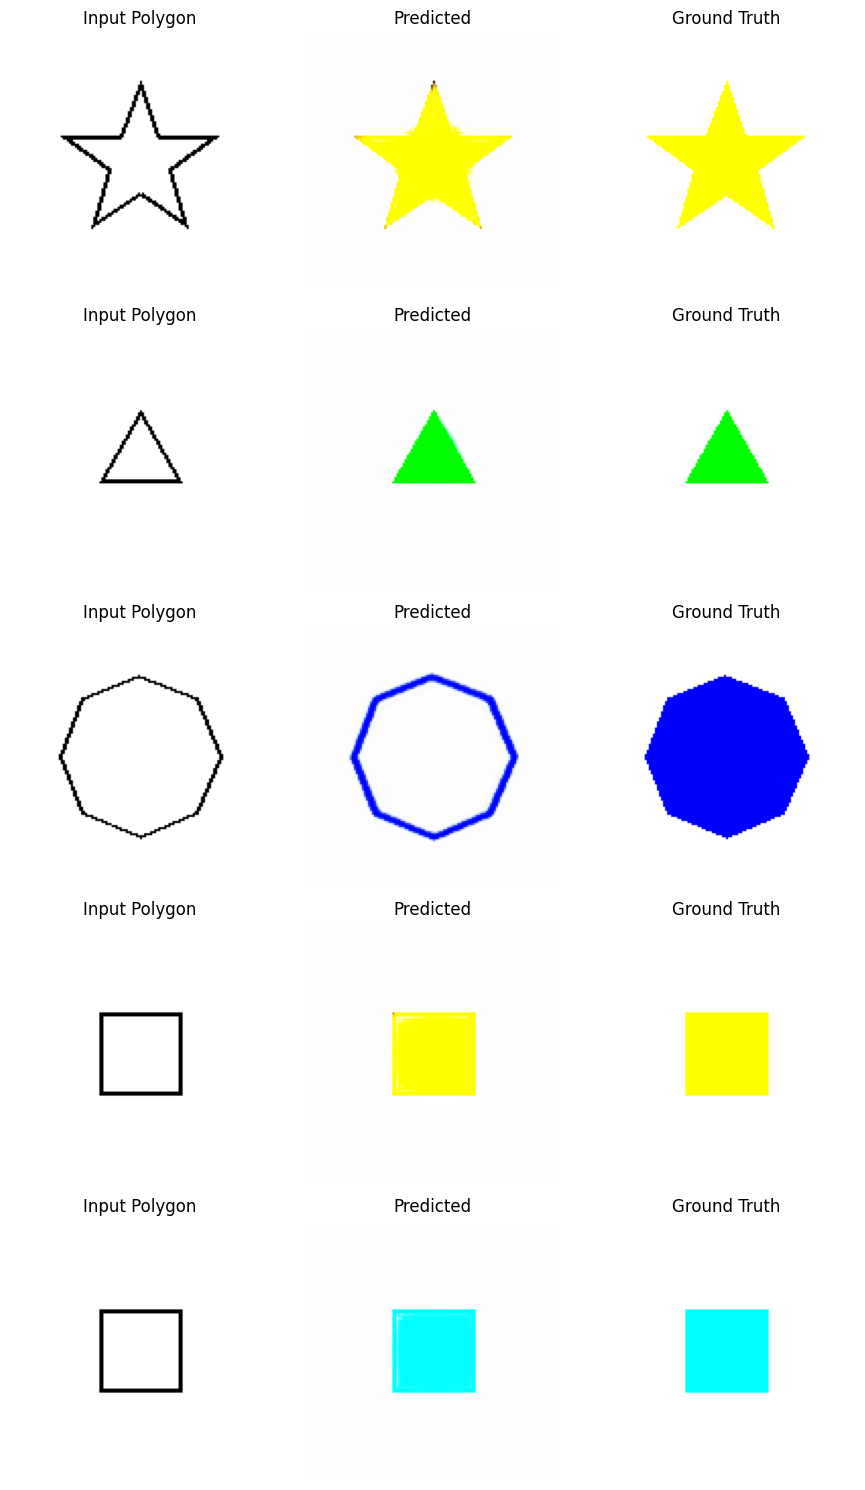

Epoch 96/140 - Train Loss: 0.0332, Val Loss: 0.0516
Epoch 97/140 - Train Loss: 0.0321, Val Loss: 0.0373
Epoch 98/140 - Train Loss: 0.0307, Val Loss: 0.0295
✨ Saved new best model at epoch 98 (val_loss=0.0295)
Epoch 99/140 - Train Loss: 0.0268, Val Loss: 0.0123
✨ Saved new best model at epoch 99 (val_loss=0.0123)
Epoch 100/140 - Train Loss: 0.0259, Val Loss: 0.0100
✨ Saved new best model at epoch 100 (val_loss=0.0100)


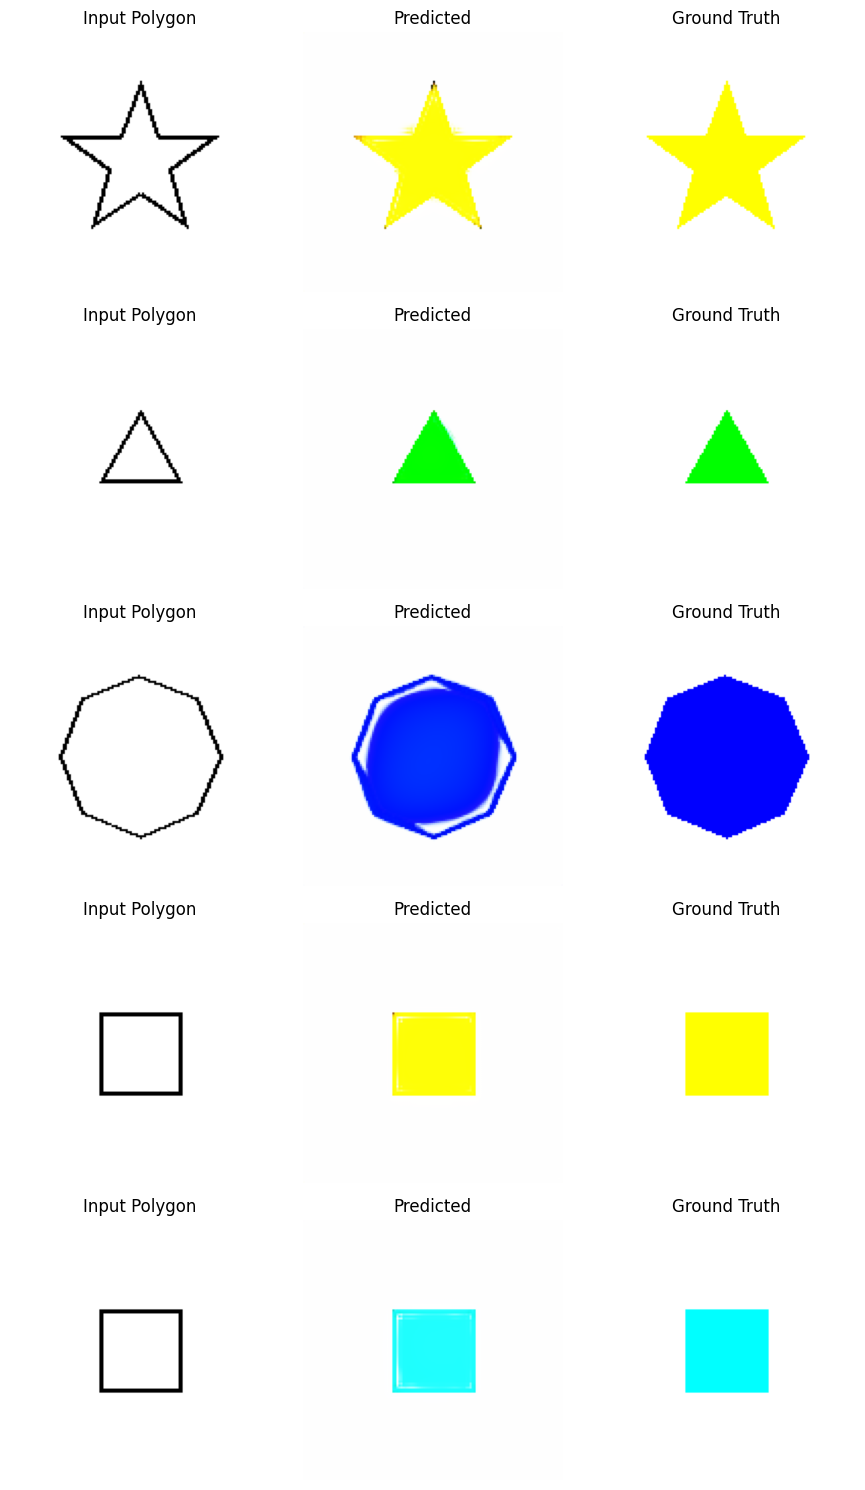

Epoch 101/140 - Train Loss: 0.0243, Val Loss: 0.0088
✨ Saved new best model at epoch 101 (val_loss=0.0088)
Epoch 102/140 - Train Loss: 0.0239, Val Loss: 0.0074
✨ Saved new best model at epoch 102 (val_loss=0.0074)
Epoch 103/140 - Train Loss: 0.0230, Val Loss: 0.0083
Epoch 104/140 - Train Loss: 0.0209, Val Loss: 0.0311
Epoch 105/140 - Train Loss: 0.0186, Val Loss: 0.0115


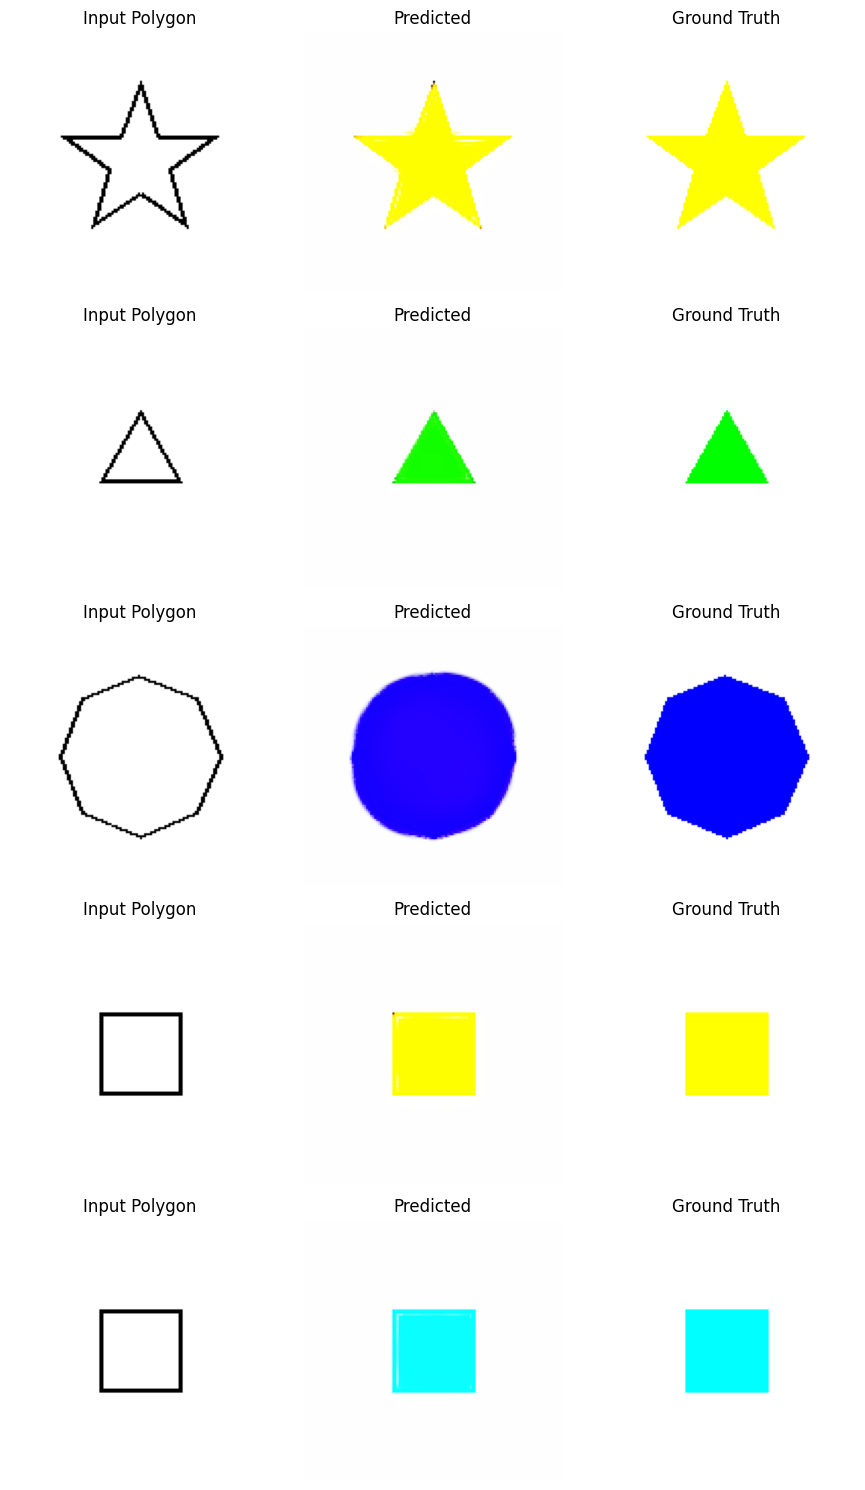

Epoch 106/140 - Train Loss: 0.0189, Val Loss: 0.0065
✨ Saved new best model at epoch 106 (val_loss=0.0065)
Epoch 107/140 - Train Loss: 0.0166, Val Loss: 0.0108
Epoch 108/140 - Train Loss: 0.0188, Val Loss: 0.0020
✨ Saved new best model at epoch 108 (val_loss=0.0020)
Epoch 109/140 - Train Loss: 0.0180, Val Loss: 0.0062
Epoch 110/140 - Train Loss: 0.0168, Val Loss: 0.0034


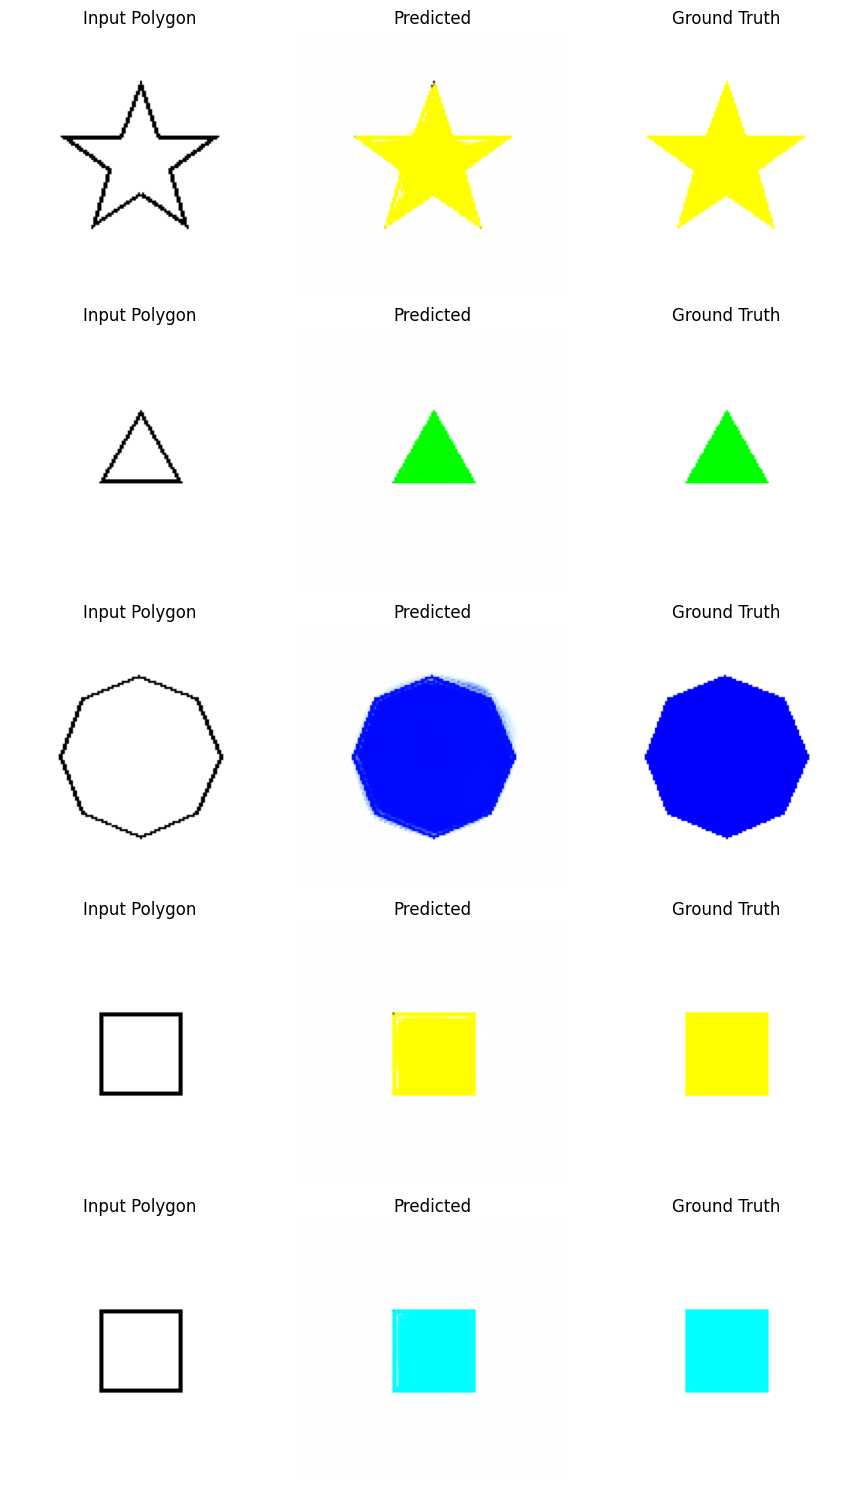

Epoch 111/140 - Train Loss: 0.0170, Val Loss: 0.0042
Epoch 112/140 - Train Loss: 0.0159, Val Loss: 0.0025
Epoch 113/140 - Train Loss: 0.0157, Val Loss: 0.0041
Epoch 114/140 - Train Loss: 0.0155, Val Loss: 0.0076
Epoch 115/140 - Train Loss: 0.0154, Val Loss: 0.0044


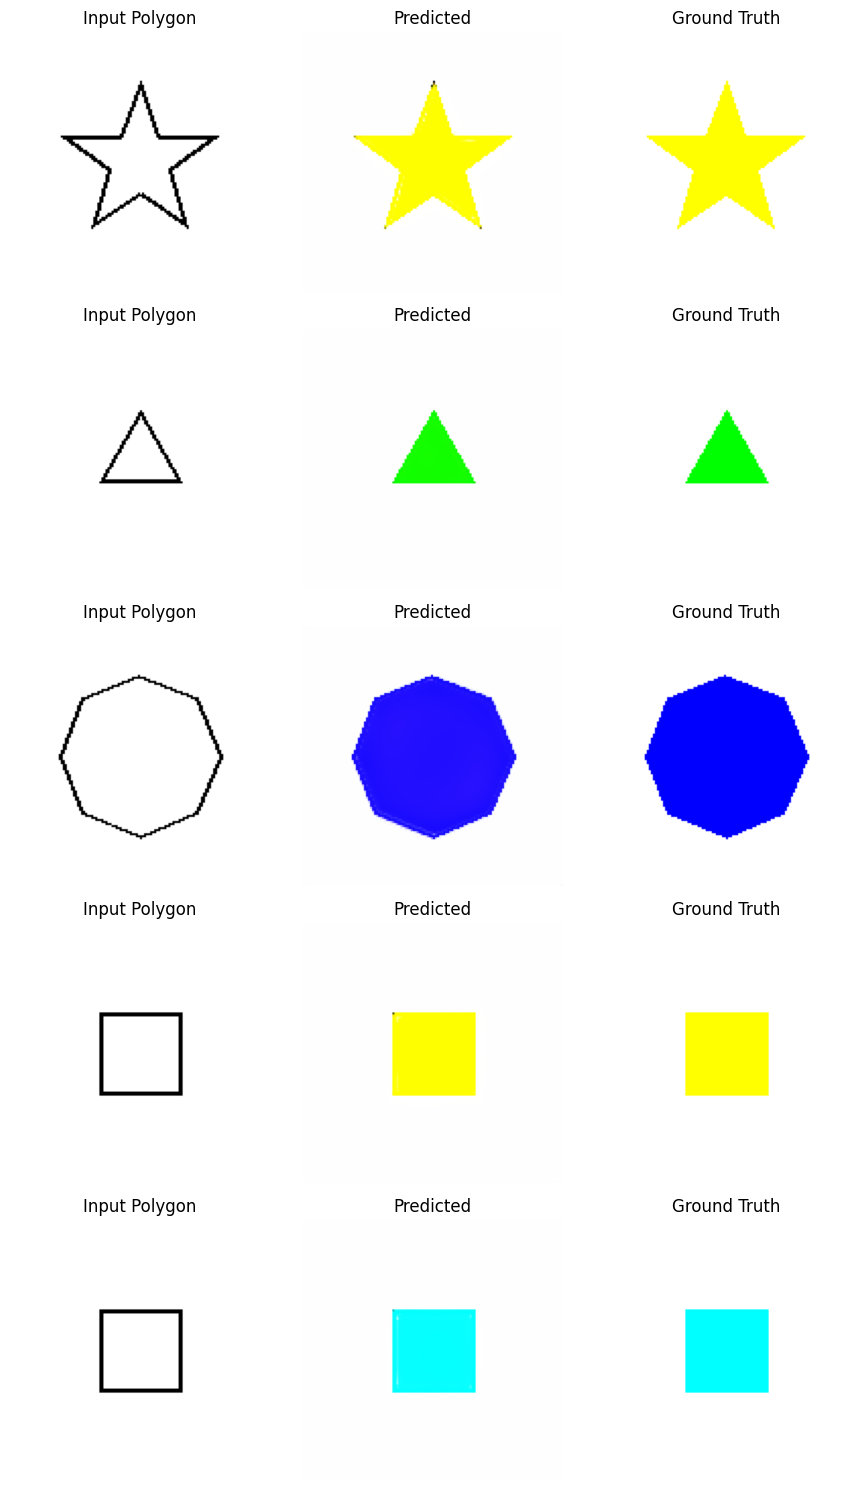

Epoch 116/140 - Train Loss: 0.0148, Val Loss: 0.0020
✨ Saved new best model at epoch 116 (val_loss=0.0020)
Epoch 117/140 - Train Loss: 0.0153, Val Loss: 0.0026
Epoch 118/140 - Train Loss: 0.0169, Val Loss: 0.0051
Epoch 119/140 - Train Loss: 0.0150, Val Loss: 0.0015
✨ Saved new best model at epoch 119 (val_loss=0.0015)
Epoch 120/140 - Train Loss: 0.0139, Val Loss: 0.0026


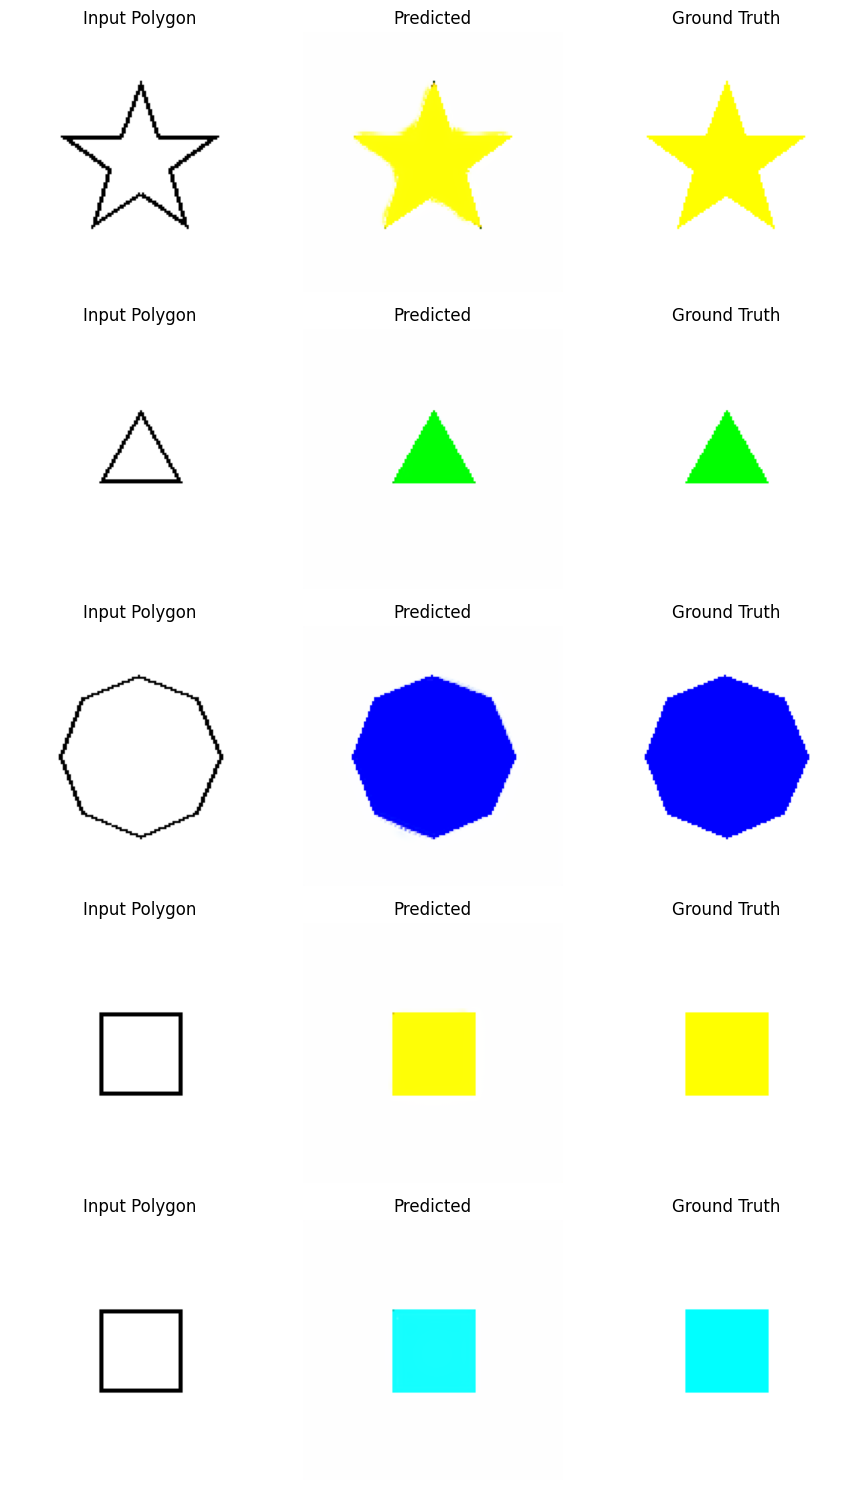

Epoch 121/140 - Train Loss: 0.0148, Val Loss: 0.0020
Epoch 122/140 - Train Loss: 0.0145, Val Loss: 0.0025
Epoch 123/140 - Train Loss: 0.0145, Val Loss: 0.0019
Epoch 124/140 - Train Loss: 0.0147, Val Loss: 0.0030
Epoch 125/140 - Train Loss: 0.0145, Val Loss: 0.0022


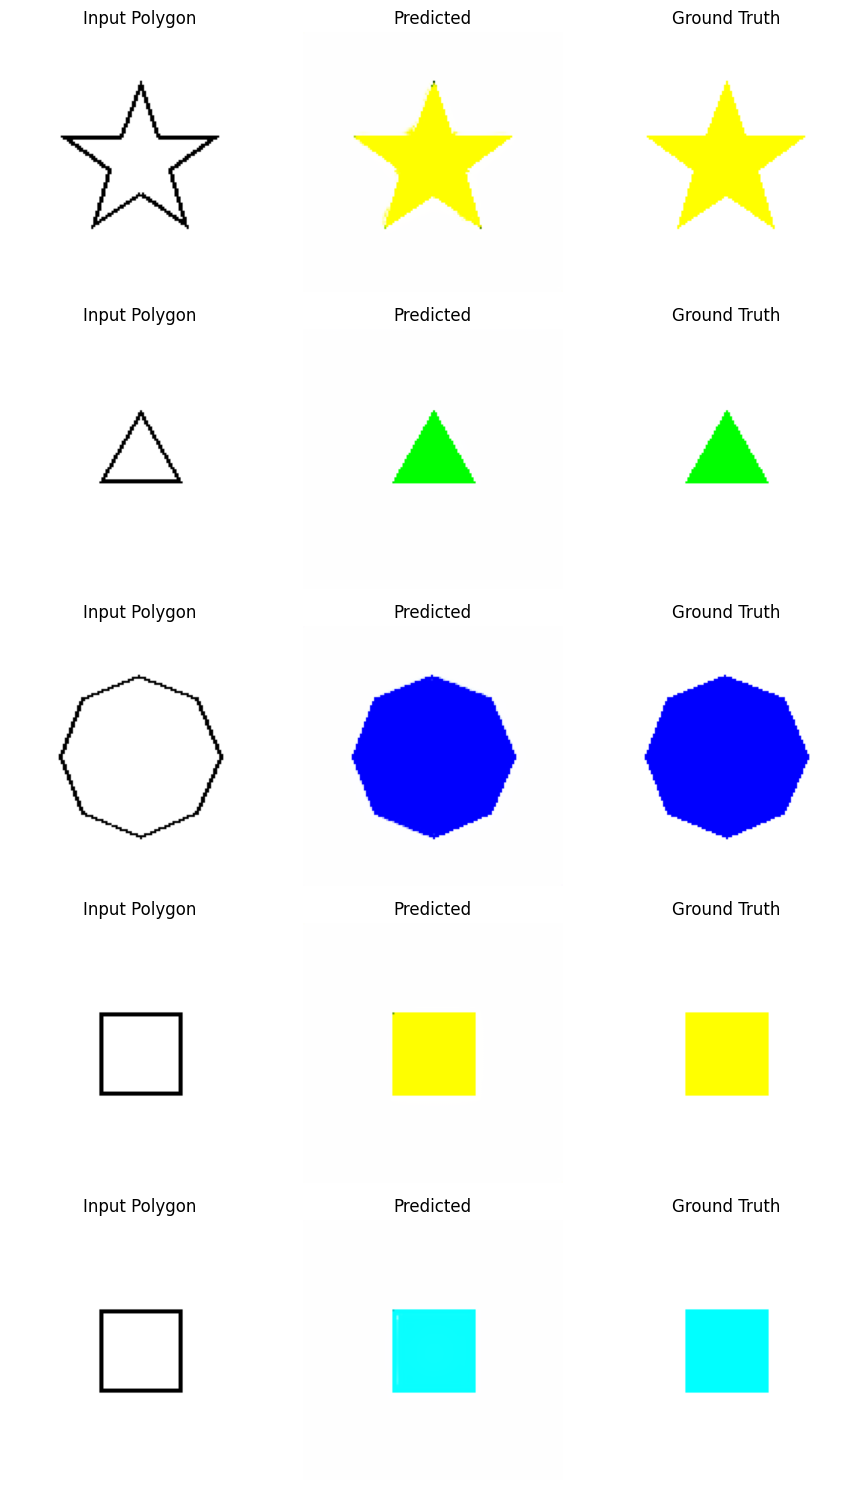

Epoch 126/140 - Train Loss: 0.0137, Val Loss: 0.0009
✨ Saved new best model at epoch 126 (val_loss=0.0009)
Epoch 127/140 - Train Loss: 0.0143, Val Loss: 0.0016
Epoch 128/140 - Train Loss: 0.0128, Val Loss: 0.0011
Epoch 129/140 - Train Loss: 0.0147, Val Loss: 0.0021
Epoch 130/140 - Train Loss: 0.0138, Val Loss: 0.0010


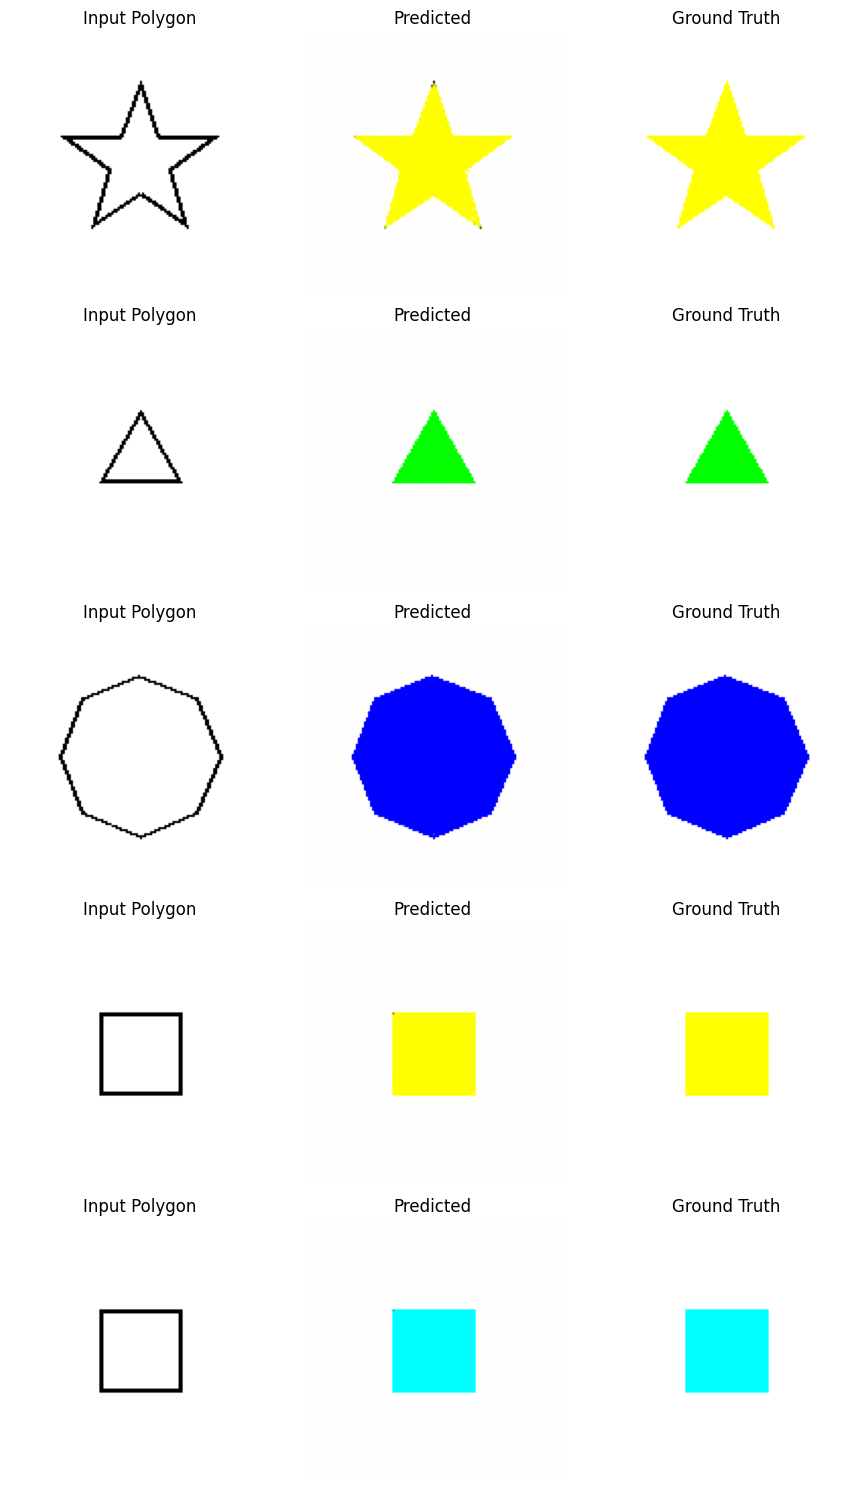

Epoch 131/140 - Train Loss: 0.0139, Val Loss: 0.0016
Epoch 132/140 - Train Loss: 0.0159, Val Loss: 0.3509
Epoch 133/140 - Train Loss: 0.0165, Val Loss: 0.0019
Epoch 134/140 - Train Loss: 0.0147, Val Loss: 0.0026
Epoch 135/140 - Train Loss: 0.0150, Val Loss: 0.0014


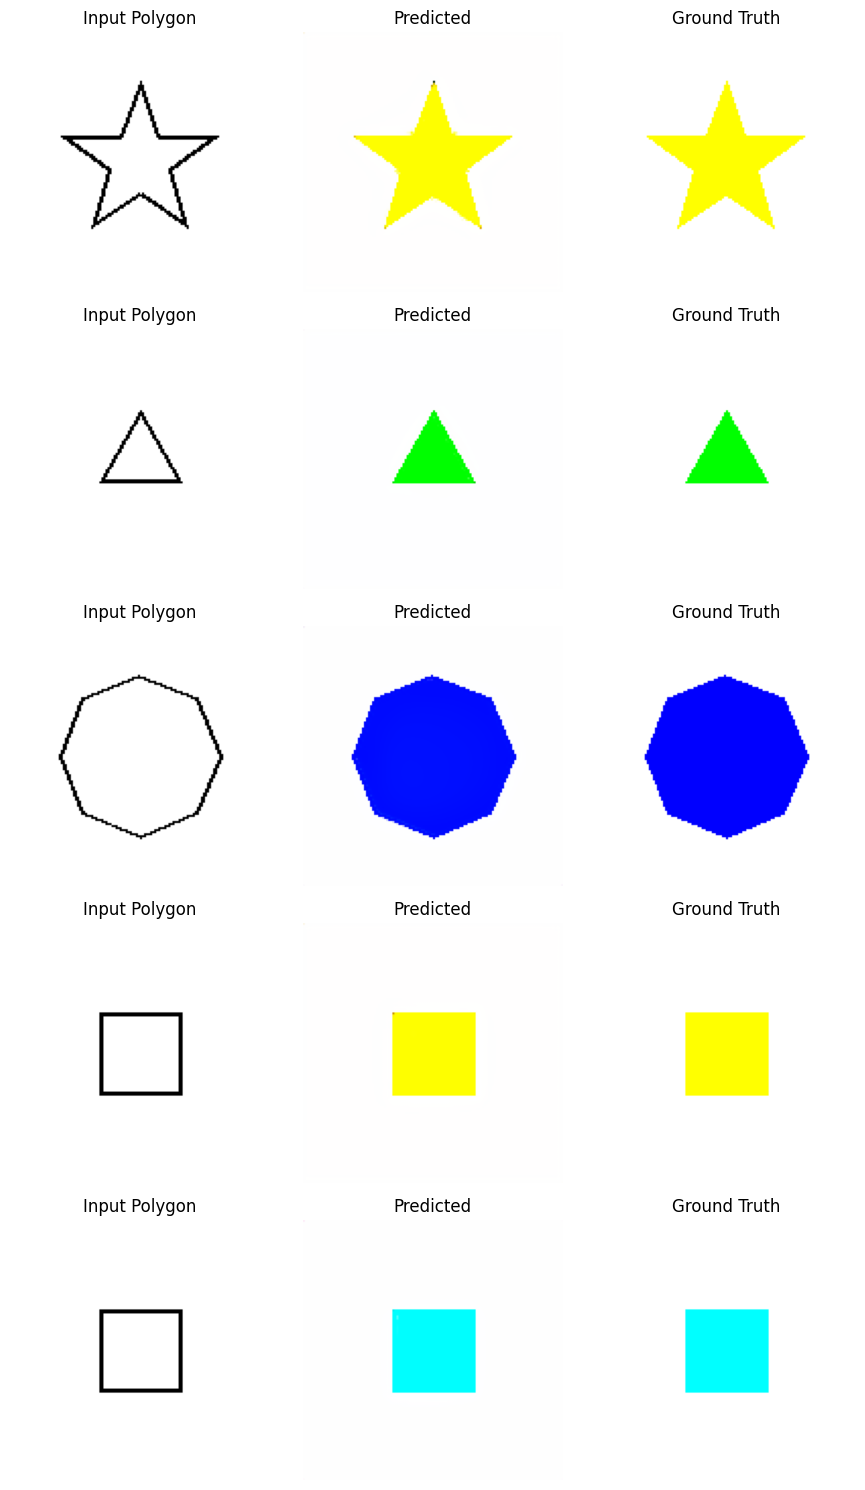

Epoch 136/140 - Train Loss: 0.0153, Val Loss: 0.0025
Epoch 137/140 - Train Loss: 0.0151, Val Loss: 0.0013
Epoch 138/140 - Train Loss: 0.0142, Val Loss: 0.0016
Epoch 139/140 - Train Loss: 0.0135, Val Loss: 0.0023
Epoch 140/140 - Train Loss: 0.0141, Val Loss: 0.0006
✨ Saved new best model at epoch 140 (val_loss=0.0006)


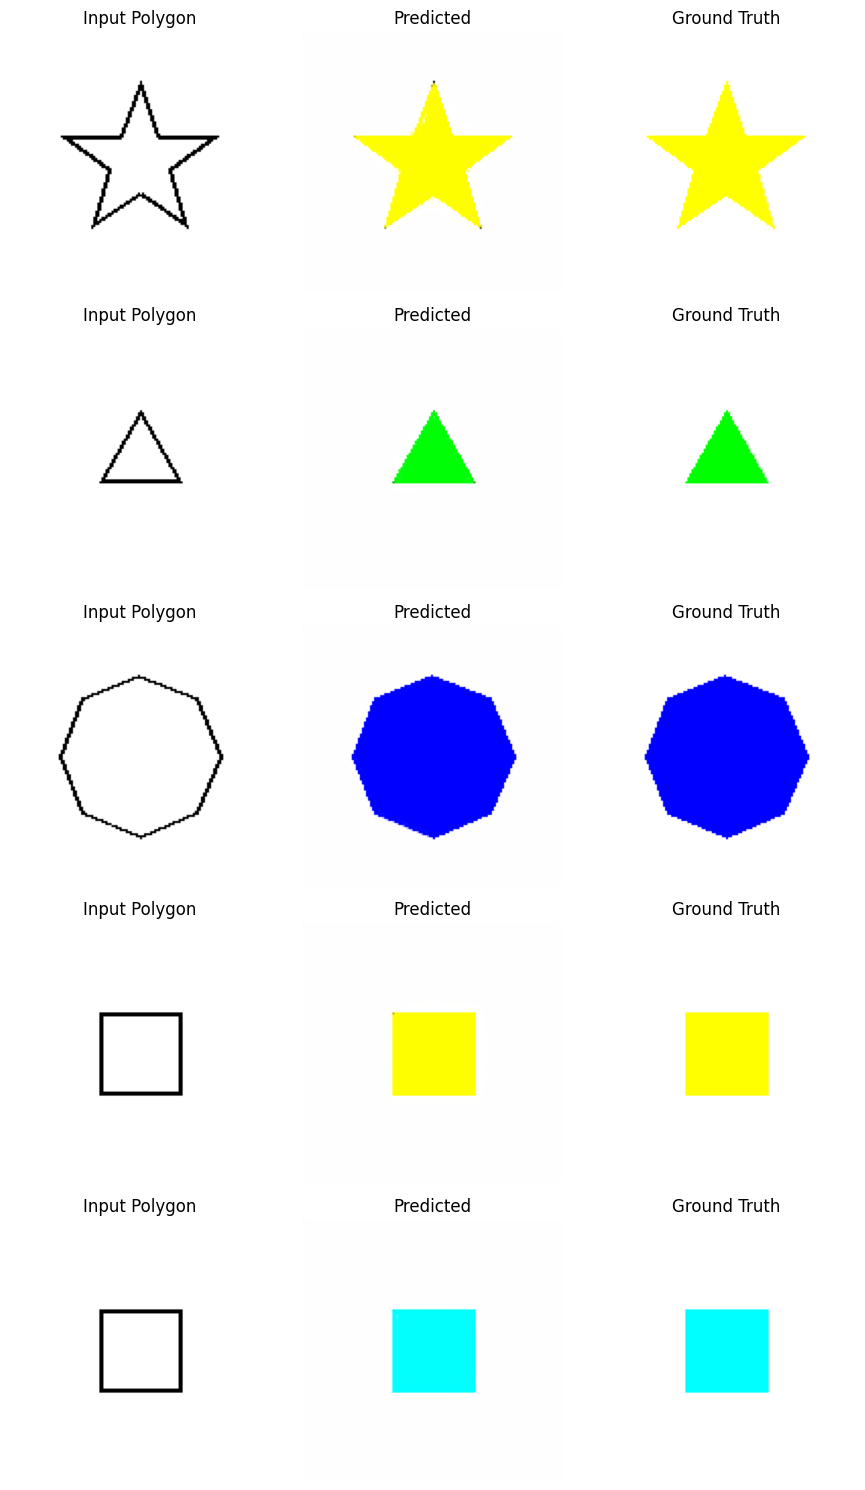

✅ Saved last epoch model


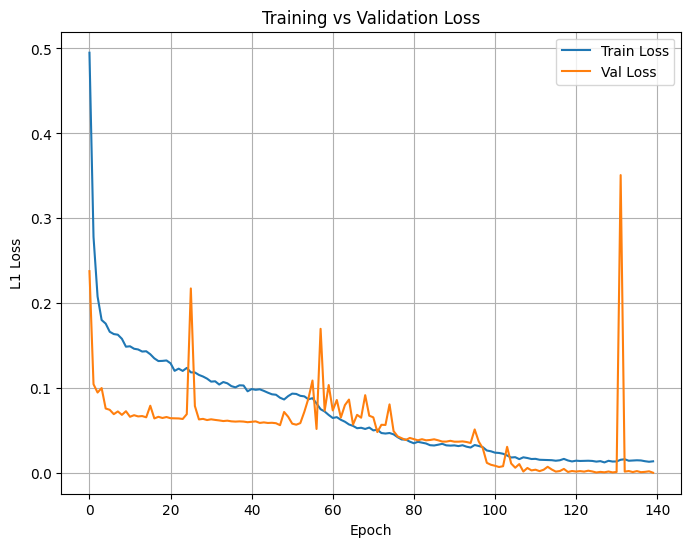

In [8]:
EPOCHS = 140
train_losses, val_losses = [], []
best_val_loss = float("inf")

for epoch in range(EPOCHS):
    # Training
    model.train()
    train_loss = 0
    for inputs, color_idx, targets in train_loader:
        inputs, color_idx, targets = inputs.to(device), color_idx.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs, color_idx)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for inputs, color_idx, targets in val_loader:
            inputs, color_idx, targets = inputs.to(device), color_idx.to(device), targets.to(device)
            outputs = model(inputs, color_idx)
            loss = criterion(outputs, targets)
            val_loss += loss.item()

    train_loss /= len(train_loader)
    val_loss /= len(val_loader)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    # 🔹 W&B logging
    wandb.log({"train_loss": train_loss, "val_loss": val_loss})

    # 🔹 Print epoch info
    print(f"Epoch {epoch+1}/{EPOCHS} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    # 🔹 Save best model (based on val loss)
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "/content/drive/MyDrive/polygon_unet_best.pth")
        print(f"✨ Saved new best model at epoch {epoch+1} (val_loss={val_loss:.4f})")

    # 🔹 Show predictions every 5 epochs
    if (epoch+1) % 5 == 0:
        inputs, color_idx, targets = next(iter(val_loader))
        inputs, color_idx, targets = inputs.to(device), color_idx.to(device), targets.to(device)
        with torch.no_grad():
            preds = model(inputs, color_idx)
            preds = torch.clamp(preds, 0, 1)  # keep values in [0,1]

        fig, axes = plt.subplots(len(inputs), 3, figsize=(9, 3*len(inputs)))
        for i in range(len(inputs)):
            axes[i,0].imshow(inputs[i].squeeze(0).cpu(), cmap="gray")
            axes[i,0].set_title("Input Polygon")
            axes[i,1].imshow(preds[i].permute(1,2,0).cpu())
            axes[i,1].set_title("Predicted")
            axes[i,2].imshow(targets[i].permute(1,2,0).cpu())
            axes[i,2].set_title("Ground Truth")
            for ax in axes[i]:
                ax.axis("off")
        plt.tight_layout()
        plt.show()


torch.save(model.state_dict(), "/content/drive/MyDrive/polygon_unet_last.pth")
print("✅ Saved last epoch model")


plt.figure(figsize=(8,6))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("L1 Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid()
plt.show()


In [14]:
# After the training loop or at a specific epoch (e.g., last epoch)
save_path = "/content/drive/MyDrive/colored_polygon_unet_full.pth"
torch.save(model, save_path)
print(f"Model saved to {save_path}")

Model saved to /content/drive/MyDrive/colored_polygon_unet_full.pth
